In [6]:
%run features_.ipynb
import re
import numpy as np
import pandas as pd
import mne
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
import multiprocessing as mp
from joblib import Parallel, delayed
from pandarallel import pandarallel
from entropy import *
from itertools import combinations, permutations
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import csv
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from mne_features.feature_extraction import extract_features
from mne_features import *
%matplotlib inline

# Parameter

In [7]:
tr_path = "C:/Users/vita7/OneDrive/Documents/Github/EEG_SleepStage_Analysis/data/SC/training_nms/"
te_path = "C:/Users/vita7/OneDrive/Documents/Github/EEG_SleepStage_Analysis/data/SC/testing/"

record_regu = r"SC\d*\D\d\-PSG.edf"
annot_regu = r"SC\d*\D\D\-Hypnogram.edf"

channel_types = {
    'EEG Fpz-Cz': 'eeg',
    'EEG Pz-Oz': 'misc',
    'EOG horizontal': 'misc',
    'Resp oro-nasal': 'misc',
    'EMG submental': 'misc',
    'Temp rectal': 'misc',
    'Event marker': 'misc'
}

sleep_stage = {
    'Sleep stage W': 1,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3': 4,
    'Sleep stage 4': 4,
    'Sleep stage R': 5
}

event_id = {
    'Sleep stage W': 1,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3/4': 4,
    'Sleep stage R': 5,
}

funcs_n = ['Hjorth_mobility','Power','STD','SpectEn', 'PermEn', 'SVD_En', 'SampEn', 'AutoCorr','Thr75']
ratio_n = [
    'EEG Fpz-Cz DTR', 'EEG Fpz-Cz DAR', 'EEG Fpz-Cz DSR', 'EEG Fpz-Cz DBR',
    'EEG Fpz-Cz TAR', 'EEG Fpz-Cz TSR', 'EEG Fpz-Cz TBR', 'EEG Fpz-Cz ASR',
    'EEG Fpz-Cz ABR', 'EEG Fpz-Cz SBR'
]
six_bands_n = [
    'EEG Fpz-Cz', 'EEG Fpz-Cz Delta', 'EEG Fpz-Cz Theta', 'EEG Fpz-Cz Alpha',
    'EEG Fpz-Cz Sigma', 'EEG Fpz-Cz Beta'
]
frbands_n = six_bands_n + ratio_n

ep_duration = 10.
sfreq = 100.
chs = 1
funcs = 9
frb = 16
partial_bands_func_idx = 8
partial_bands = [[1]]

# DataTransfer

### Record name

In [8]:
record_name = []
annot_name = []

events = []  # events
for file_name in os.listdir(tr_path):
    match1 = re.search(record_regu, file_name)
    match2 = re.search(annot_regu, file_name)
    if (match1):
        record_name.append(match1.group())
    elif (match2):
        annot_name.append(match2.group())

if (len(record_name) != len(annot_name)):
    record_name = []
    annot_name = []

df = pd.concat([pd.DataFrame(record_name), pd.DataFrame(annot_name)], axis=1)
df.columns = ['Records', 'Hypnogram']
df

Records               Hypnogram
0  SC4001E0-PSG.edf  SC4001EC-Hypnogram.edf
1  SC4051E0-PSG.edf  SC4051EC-Hypnogram.edf
2  SC4151E0-PSG.edf  SC4151EC-Hypnogram.edf
3  SC4182E0-PSG.edf  SC4182EC-Hypnogram.edf
4  SC4312E0-PSG.edf  SC4312EM-Hypnogram.edf
5  SC4451F0-PSG.edf  SC4451FY-Hypnogram.edf
6  SC4592G0-PSG.edf  SC4592GY-Hypnogram.edf
7  SC4812G0-PSG.edf  SC4812GV-Hypnogram.edf

### Read data

In [9]:
raw_ = []  # raw
events_ = []  # events

for ren, an in zip(record_name, annot_name):
    print('\n\033[5;31;47m File name:\n %s\033[0m\n' % (ren))
    rec = mne.io.read_raw_edf(tr_path + ren, preload=True)
    ann = mne.read_annotations(tr_path + an)

    # set annotations
    rec.set_annotations(ann, emit_warning=True)
    rec.set_channel_types(channel_types)
    rec.filter(0.5, 30, picks=['eeg'])
    ev, _ = mne.events_from_annotations(rec,
                                        use_rounding=False,
                                        event_id=sleep_stage,
                                        chunk_duration=ep_duration)

    events_.append(ev)
    raw_.append(rec)


 File name:
 SC4001E0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.610 sec)



<ipython-input-9-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']

 File name:
 SC4051E0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4051E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8165999  =      0.000 ... 81659.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.61

<ipython-input-9-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']

 File name:
 SC4151E0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4151E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7859999  =      0.000 ... 78599.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.61

<ipython-input-9-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']

 File name:
 SC4182E0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4182E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8525999  =      0.000 ... 85259.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.61

<ipython-input-9-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']

 File name:
 SC4312E0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4312E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8099999  =      0.000 ... 80999.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.61

<ipython-input-9-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']

 File name:
 SC4451F0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4451F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8369999  =      0.000 ... 83699.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.61

<ipython-input-9-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']

 File name:
 SC4592G0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4592G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6119999  =      0.000 ... 61199.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.61

<ipython-input-9-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']

 File name:
 SC4812G0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4812G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7247999  =      0.000 ... 72479.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.61

<ipython-input-9-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


### EP records

In [10]:
epochs_ = []
tmax = ep_duration - 1 / rec.info['sfreq']
for raw, eve in zip(raw_, events_):
    ep = mne.Epochs(
        raw=raw,
        picks=['eeg'],
        events=eve,
        event_id=event_id,
        tmin=0.,
        tmax=tmax,
        baseline=None,  # 1 epoch data - mean ( 1 epoch data)
        detrend=None,  # linear detrend
    )
    epochs_.append(ep)

7950 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
8166 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
7848 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
8526 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
8100 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
8370 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
6120 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
7242 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


### EP Dataframe

In [11]:
ep_df_ = []
for eps in epochs_:
    df = eps.to_data_frame()

    # data balance
    con_len = list(
        df.groupby(level=['condition']).count()['EEG Fpz-Cz'] /
        (ep_duration * sfreq))  # epochs
    drop_len = np.floor(con_len[-1] - np.mean(con_len[:4]))  # epochs
    df = df[int(np.floor(drop_len / 2) *
                (ep_duration * sfreq)):int((np.sum(con_len) -
                                            np.floor(drop_len / 2)) *
                                           (ep_duration * sfreq))]

    # 5 frequency bands
    df['EEG Fpz-Cz Delta'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                                    sfreq=100,
                                                    l_freq=0.5,
                                                    h_freq=4.5)
    df['EEG Fpz-Cz Theta'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                                    sfreq=100,
                                                    l_freq=4.5,
                                                    h_freq=8.5)
    df['EEG Fpz-Cz Alpha'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                                    sfreq=100,
                                                    l_freq=8.5,
                                                    h_freq=11.5)
    df['EEG Fpz-Cz Sigma'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                                    sfreq=100,
                                                    l_freq=11.5,
                                                    h_freq=15.5)
    df['EEG Fpz-Cz Beta'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                                   sfreq=100,
                                                   l_freq=15.5,
                                                   h_freq=30)

    ep_df_.append(df)

Loading data for 7950 events and 1000 original time points ...
0 bad epochs dropped
Converting "time" to "<class 'numpy.int64'>"...
Setting up band-pass filter from 0.5 - 4.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Filter length: 661 samples (6.610 sec)

Setting up band-pass filter from 4.5 - 8.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.50
- Lower transition bandwidth: 2.00 Hz (-6 dB 


Loading data for 8526 events and 1000 original time points ...
0 bad epochs dropped
Converting "time" to "<class 'numpy.int64'>"...
Setting up band-pass filter from 0.5 - 4.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Filter length: 661 samples (6.610 sec)

Setting up band-pass filter from 4.5 - 8.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.50
- Lower transition bandwidth: 2.00 Hz (-6 dB


Loading data for 6120 events and 1000 original time points ...
0 bad epochs dropped
Converting "time" to "<class 'numpy.int64'>"...
Setting up band-pass filter from 0.5 - 4.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Filter length: 661 samples (6.610 sec)

Setting up band-pass filter from 4.5 - 8.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.50
- Lower transition bandwidth: 2.00 Hz (-6 dB

# Information

In [12]:
for df in ep_df_:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2450000 entries, (Sleep stage W, 2750, 0) to (Sleep stage W, 5199, 9990)
Data columns (total 6 columns):
EEG Fpz-Cz          float64
EEG Fpz-Cz Delta    float64
EEG Fpz-Cz Theta    float64
EEG Fpz-Cz Alpha    float64
EEG Fpz-Cz Sigma    float64
EEG Fpz-Cz Beta     float64
dtypes: float64(6)
memory usage: 123.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1740000 entries, (Sleep stage W, 3213, 0) to (Sleep stage 3/4, 4952, 9990)
Data columns (total 6 columns):
EEG Fpz-Cz          float64
EEG Fpz-Cz Delta    float64
EEG Fpz-Cz Theta    float64
EEG Fpz-Cz Alpha    float64
EEG Fpz-Cz Sigma    float64
EEG Fpz-Cz Beta     float64
dtypes: float64(6)
memory usage: 88.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2926000 entries, (Sleep stage W, 2461, 0) to (Sleep stage W, 5386, 9990)
Data columns (total 6 columns):
EEG Fpz-Cz          float64
EEG Fpz-Cz Delta    float64
EEG Fpz-Cz Theta    float64
EEG Fpz-Cz Alpha  

In [13]:
temp = pd.DataFrame()
for df in ep_df_:
    temp = pd.concat(
        [temp,
         df.groupby(level=['condition']).count()['EEG Fpz-Cz'] / 1000.],
        axis=1)
temp.columns = record_name
temp = temp.T
temp['total'] = np.sum(temp, axis=1)
temp

C:\Users\vita7\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


condition         Sleep stage 1  Sleep stage 2  Sleep stage 3/4  \
SC4001E0-PSG.edf          159.0          750.0            660.0   
SC4051E0-PSG.edf           93.0          405.0            255.0   
SC4151E0-PSG.edf          123.0         1062.0            531.0   
SC4182E0-PSG.edf          453.0          870.0            648.0   
SC4312E0-PSG.edf          374.0          828.0            573.0   
SC4451F0-PSG.edf          459.0          696.0            921.0   
SC4592G0-PSG.edf          270.0          426.0            168.0   
SC4812G0-PSG.edf          204.0          658.0            300.0   

condition         Sleep stage R  Sleep stage W   total  
SC4001E0-PSG.edf          375.0          506.0  2450.0  
SC4051E0-PSG.edf          132.0          855.0  1740.0  
SC4151E0-PSG.edf          624.0          586.0  2926.0  
SC4182E0-PSG.edf          348.0          581.0  2900.0  
SC4312E0-PSG.edf          573.0          908.0  3256.0  
SC4451F0-PSG.edf          336.0         1110.0  3522.0  
SC4592G0-PSG.edf          180.0         1684.0  2728.0  
SC4812G0-PSG.edf          240.0         1318.0  2720.0

In [14]:
temp = []

for df in ep_df_:
    temp.append(df.describe())

des = pd.concat(temp,axis=0,keys=range(8))
des.to_csv('training_record_des.csv')
des

channel    EEG Fpz-Cz  EEG Fpz-Cz Delta  EEG Fpz-Cz Theta  EEG Fpz-Cz Alpha  \
0 count  2.450000e+06      2.450000e+06      2.450000e+06      2.450000e+06   
  mean  -1.464151e-04     -4.234948e-04      3.350748e-06      7.645613e-08   
  std    2.225614e+01      2.119256e+01      6.166780e+00      2.893816e+00   
  min   -1.723292e+02     -1.572540e+02     -6.707452e+01     -2.613432e+01   
  25%   -1.014009e+01     -9.057221e+00     -3.461199e+00     -1.698791e+00   
  50%   -2.317605e-02     -3.609500e-02     -5.231356e-03      7.981103e-05   
  75%    1.012681e+01      9.050902e+00      3.459931e+00      1.698818e+00   
  max    1.544175e+02      1.562999e+02      6.330683e+01      2.524565e+01   
1 count  1.740000e+06      1.740000e+06      1.740000e+06      1.740000e+06   
  mean  -4.016231e-04      5.110988e-04      3.897747e-06     -9.527052e-06   
  std    2.277774e+01      2.096546e+01      7.123552e+00      4.837142e+00   
  min   -1.810411e+02     -1.865010e+02     -6.968656e+01     -2.860338e+01   
  25%   -1.050045e+01     -8.381751e+00     -4.101357e+00     -2.640692e+00   
  50%   -1.795966e-01     -8.690280e-02     -1.785294e-02      3.510732e-04   
  75%    1.030986e+01      8.261192e+00      4.069569e+00      2.642204e+00   
  max    1.760242e+02      1.803540e+02      6.628523e+01      2.908043e+01   
2 count  2.926000e+06      2.926000e+06      2.926000e+06      2.926000e+06   
  mean   9.306676e-04      8.501512e-04      5.819939e-06     -2.746959e-06   
  std    1.727111e+01      1.621877e+01      4.761105e+00      2.293269e+00   
  min   -1.463005e+02     -1.336889e+02     -5.076628e+01     -3.888014e+01   
  25%   -8.244965e+00     -7.337489e+00     -2.618560e+00     -1.300558e+00   
  50%   -7.305503e-02     -5.146195e-02     -8.251388e-03      2.158779e-04   
  75%    8.134861e+00      7.279390e+00      2.601113e+00      1.302599e+00   
  max    1.345532e+02      1.178235e+02      5.261812e+01      3.632160e+01   
3 count  2.900000e+06      2.900000e+06      2.900000e+06      2.900000e+06   
  mean  -5.892847e-05     -4.505567e-05      4.862864e-06     -1.905454e-06   
  std    1.840008e+01      1.715836e+01      5.637346e+00      2.749360e+00   
  min   -1.630907e+02     -1.471755e+02     -7.960189e+01     -4.474441e+01   
  25%   -7.813775e+00     -6.585944e+00     -2.928561e+00     -1.482794e+00   
  50%   -1.488105e-01     -1.134238e-01     -1.123850e-02      5.203007e-04   
...               ...               ...               ...               ...   
4 std    1.887684e+01      1.728928e+01      5.544088e+00      3.624326e+00   
  min   -1.526288e+02     -1.319393e+02     -5.737225e+01     -3.493486e+01   
  25%   -9.053544e+00     -7.282898e+00     -3.110756e+00     -1.849744e+00   
  50%   -2.726887e-02     -3.592907e-02     -3.299884e-03      8.183755e-04   
  75%    8.980433e+00      7.233869e+00      3.101362e+00      1.852074e+00   
  max    1.570475e+02      1.424385e+02      5.177133e+01      3.672561e+01   
5 count  3.522000e+06      3.522000e+06      3.522000e+06      3.522000e+06   
  mean  -3.899871e-05     -1.075491e-05     -7.473706e-06      4.984523e-07   
  std    1.887967e+01      1.720476e+01      5.051375e+00      3.433993e+00   
  min   -1.761033e+02     -1.423352e+02     -8.140962e+01     -6.475338e+01   
  25%   -9.235882e+00     -7.455608e+00     -2.775209e+00     -1.862299e+00   
  50%    5.151262e-02      9.609342e-02     -9.913547e-04      1.419348e-03   
  75%    9.319342e+00      7.525348e+00      2.780740e+00      1.863402e+00   
  max    1.598806e+02      1.432740e+02      7.042240e+01      6.258961e+01   
6 count  2.728000e+06      2.728000e+06      2.728000e+06      2.728000e+06   
  mean   3.194425e-04      1.363503e-04     -1.397001e-05      3.143678e-06   
  std    2.098627e+01      1.950738e+01      5.001279e+00      3.103022e+00   
  min   -2.004953e+02     -1.990550e+02     -8.494419e+01     -5.258201e+01   
  25%   -8.603905e+00     -7.583050e+00     -2.646

# RAW Preprocessing

### Spectrum

In [15]:
fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(80, 60))

for df, n in zip(ep_df_, range(len(ep_df_))):
    clist = list(df.columns)
    for c in clist:
        axes[n, clist.index(c)].set_title((n, c))
        axes[n, clist.index(c)].magnitude_spectrum(np.array(df[c]), Fs=sfreq)

plt.savefig('Magnitude Spectrum.png')

# Features calculation

In [16]:
# multi processing
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=mp.cpu_count())(delayed(func)(group)
                                             for name, group in dfGrouped)
    return pd.concat(retLst, axis=1).T

"""Functions format.

1. MNE - features : univariate

    temps.append(
        applyParallel(
            grouped,
            lambda x: pd.Series(univariate.compute_XXX(x.T.values))).set_index(midx))

2. NUMPY

    2.1
        temps.append(grouped.XXX(PPP))

3. STATS

    temps.append(
    applyParallel(
        grouped,
        lambda x: x.apply(stats.XXX,PPP,axis=0)).set_index(midx))

4. Entropy
    temps.append(
        applyParallel(
            grouped, lambda x: x.apply(XXX,PPP,axis=0)).set_index(midx))

5. USER DEF

    temps.append(
        applyParallel(
            grouped, lambda x: x.apply(XXX,PPP,,axis=0)).set_index(midx))
"""

In [17]:
def Features_Calculate(df, f=None, b=None):
    grouped = df.groupby(level=['epoch', 'condition'])
    temps = []
    midx = []

    # multiIndex
    for idx, gr in grouped:
        midx.append(idx)
    midx = pd.MultiIndex.from_tuples(midx, names=('epoch', 'condition'))
    """---------------------------------------------------------------------------------------------------------------------------"""
    temps.append(
        applyParallel(
            grouped, lambda x: pd.Series(
                univariate.compute_hjorth_mobility(x.T.values))).set_index(midx))

    # Power
    temps.append(
        applyParallel(
            grouped,
            lambda x: x.apply(Power, sfreq=sfreq, axis=0)).set_index(midx))

    # STD
    temps.append(grouped.std())

    # SpectEn
    temps.append(
        applyParallel(
            grouped, lambda x: x.apply(spectral_entropy,
                                       sf=sfreq,
                                       method='welch',
                                       normalize=False,
                                       axis=0)).set_index(midx))

    # PermEn
    temps.append(
        applyParallel(
            grouped, lambda x: x.apply(perm_entropy, order=3, delay=1, axis=0)
        ).set_index(midx))

    # SVD_En
    temps.append(
        applyParallel(
            grouped, lambda x: x.apply(
                svd_entropy, order=3, delay=1, normalize=False, axis=0)).
        set_index(midx))

    # SampEn
    temps.append(
        applyParallel(
            grouped,
            lambda x: x.apply(sample_entropy, order=2, axis=0)).set_index(
                midx))

    # USER DEF
    temps.append(
        applyParallel(
            grouped, lambda x: x.apply(AutoCorr, k=1, axis=0)).set_index(midx))
    """---------------------------------------------------------------------------------------------------------------------------"""

    temps.append(
        applyParallel(grouped,
                      lambda x: x.apply(ThresholdVol, thr=75, axis=0))[[
                          six_bands_n[i] for i in b[0]
                      ]].set_index(midx))
    """---------------------------------------------------------------------------------------------------------------------------"""

    res = pd.concat(temps, axis=1)

    if (f == b == None):
        cols = [(i, j) for i in funcs_n[:f] for j in six_bands_n]
    else:
        cols = [(i, j) for i in funcs_n[:f] for j in six_bands_n] + [
            (i, j) for i in funcs_n[f:]
            for j in [six_bands_n[k] for k in b[list.index(funcs_n, i) - f]]
        ]
    res.columns = pd.MultiIndex.from_tuples(tuples=cols,
                                            names=['Function', 'Band'])

    return res

In [18]:
temp = []

st = time.time()
for df in ep_df_:
    temp.append(
        Features_Calculate(df, f=partial_bands_func_idx, b=partial_bands))
tr_df = pd.concat(temp, axis=0)

et = time.time()
print('time-consuming: %f' % (et - st))

time-consuming: 341.364846


In [19]:
tr_df = pd.concat(temp, axis=0)
tr_df.head()

Function            Hjorth_mobility                                    \
Band                     EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta   
epoch condition                                                         
2750  Sleep stage W        0.210770         0.108411         0.333452   
2751  Sleep stage W        0.265567         0.135344         0.323986   
2752  Sleep stage W        0.225223         0.130442         0.321501   
2753  Sleep stage W        0.265103         0.115991         0.344513   
2754  Sleep stage W        0.245674         0.143645         0.344098   

Function                                                               \
Band                EEG Fpz-Cz Alpha EEG Fpz-Cz Sigma EEG Fpz-Cz Beta   
epoch condition                                                         
2750  Sleep stage W         0.600818         0.813715        1.323957   
2751  Sleep stage W         0.609243         0.818061        1.317721   
2752  Sleep stage W         0.597755         0.800419        1.296896   
2753  Sleep stage W         0.599916         0.821229        1.337113   
2754  Sleep stage W         0.582714         0.841317        1.292150   

Function                   Power                                    \
Band                  EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta   
epoch condition                                                      
2750  Sleep stage W  2912.773799      2679.337798       179.873143   
2751  Sleep stage W  1598.415560      1469.364384       163.543750   
2752  Sleep stage W  2071.434840      1940.462101       176.482817   
2753  Sleep stage W  2681.941567      2374.589675       191.187069   
2754  Sleep stage W  2119.188675      1934.482692       199.268822   

Function                                   ...                  SampEn  \
Band                EEG Fpz-Cz Alpha       ...        EEG Fpz-Cz Alpha   
epoch condition                            ...                           
2750  Sleep stage W        23.654926       ...                0.622485   
2751  Sleep stage W        23.568927       ...                0.628287   
2752  Sleep stage W        23.886011       ...                0.616738   
2753  Sleep stage W        41.315575       ...                0.611738   
2754  Sleep stage W        24.432526       ...                0.617204   

Function                                               AutoCorr  \
Band                EEG Fpz-Cz Sigma EEG Fpz-Cz Beta EEG Fpz-Cz   
epoch condition                                                   
2750  Sleep stage W         0.755880        1.617767   0.977667   
2751  Sleep stage W         0.740053        1.534523   0.965642   
2752  Sleep stage W         0.725153        1.486089   0.974621   
2753  Sleep stage W         0.698729        1.196411   0.963653   
2754  Sleep stage W         0.752756        1.635461   0.973309   

Function                                                                \
Band                EEG Fpz-Cz Delta EEG Fpz-Cz Theta EEG Fpz-Cz Alpha   
epoch condition                                                          
2750  Sleep stage W         0.994010         0.943813         0.819424   
2751  Sleep stage W         0.991236         0.948917         0.814643   
2752  Sleep stage W         0.991409         0.947258         0.821590   
2753  Sleep stage W         0.991792         0.941834         0.819554   
2754  Sleep stage W         0.993970         0.942251         0.831757   

Function                                                        Thr75  
Band                EEG Fpz-Cz Sigma EEG Fpz-Cz Beta EEG Fpz-Cz Delta  
epoch condition                                                        
2750  Sleep stage W         0.669260        0.124444               23  
2751  Sleep stage W         0.666057        0.132910                1  
2752  Sleep stage W         0.679827        0.159802                1  
2753  Sleep stage W         0.663158        0.106962                1  
2754  Sleep stage W         0.645630      

# Preprocessing

### Missing value dection

In [20]:
tr_df.describe().to_csv('des_0.csv')
tr_df.describe()

Function Hjorth_mobility                                                     \
Band          EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta EEG Fpz-Cz Alpha   
count       22242.000000     22242.000000     22242.000000     22242.000000   
mean            0.329373         0.122106         0.377792         0.606094   
std             0.173170         0.027107         0.037749         0.027557   
min             0.050370         0.041031         0.298147         0.489714   
25%             0.205494         0.102112         0.350431         0.589078   
50%             0.287967         0.120816         0.370306         0.606422   
75%             0.400406         0.140966         0.397584         0.623089   
max             1.126451         0.233315         0.518735         0.720693   

Function                                          Power                   \
Band     EEG Fpz-Cz Sigma EEG Fpz-Cz Beta    EEG Fpz-Cz EEG Fpz-Cz Delta   
count        22242.000000    22242.000000  22242.000000     22242.000000   
mean             0.803035        1.212015   1120.822067       972.039868   
std              0.027311        0.095688   1357.619459      1244.950437   
min              0.694517        0.933509     36.088438        17.955147   
25%              0.784015        1.137291    289.400046       198.820571   
50%              0.803720        1.221999    645.300702       518.867981   
75%              0.822460        1.289729   1481.854650      1313.799618   
max              0.895733        1.489423  26308.411262     25347.385914   

Function                                         ...                  SampEn  \
Band     EEG Fpz-Cz Theta EEG Fpz-Cz Alpha       ...        EEG Fpz-Cz Alpha   
count        22242.000000     22242.000000       ...            22242.000000   
mean            91.540375        33.520790       ...                0.605835   
std             77.737270        39.019078       ...                0.035369   
min              7.707003         1.811558       ...                0.111053   
25%             43.207948        13.440402       ...                0.587579   
50%             68.663059        21.735297       ...                0.609001   
75%            113.512384        38.126206       ...                0.627626   
max           1640.268784      1370.424041       ...                0.738411   

Function                                       AutoCorr                   \
Band     EEG Fpz-Cz Sigma EEG Fpz-Cz Beta    EEG Fpz-Cz EEG Fpz-Cz Delta   
count        22242.000000    22242.000000  22242.000000     22242.000000   
mean             0.681038        1.522441      0.931278         0.992700   
std              0.097235        0.172021      0.080866         0.003731   
min              0.101745        0.090224      0.365749         0.935077   
25%              0.615580        1.449569      0.920172         0.990476   
50%              0.693246        1.555192      0.959073         0.993209   
75%              0.751819        1.635123      0.979357         0.995304   
max              1.040972        1.869123      1.003181         1.017139   

Function                                                                     \
Band     EEG Fpz-Cz Theta EEG Fpz-Cz Alpha EEG Fpz-Cz Sigma EEG Fpz-Cz Beta   
count        22242.000000     22242.000000     22242.000000    22242.000000   
mean             0.928446         0.816471         0.677700        0.261431   
std              0.014989         0.016772         0.021917        0.114816   
min              0.864745         0.741115         0.599653       -0.108120   
25%              0.921503         0.806446         0.662197        0.168948   
50%              0.931890         0.816698         0.677551        0.253964   
75%              0.939149         0.827029         0.693165        0.353846   
max              0.970999         0.880498         0.759090        0.564694   

Function            Thr75  
Band     EEG Fpz-Cz Delta  
count        22242.000000  
mean       

In [21]:
# inf value processing
tr_df.replace([np.inf,-np.inf],np.nan,inplace = True)
# missing value processing
tr_df.dropna(inplace=True)

In [22]:
# Feature cross
lev1_comblist = list(
    combinations(list(tr_df.columns.get_level_values(1).unique())[1:], r=2))
ls = list(tr_df.columns.get_level_values(0).unique())[:partial_bands_func_idx]

for fes in ls:
    cInd = int((ls.index(fes)+1)*len(six_bands_n)+ls.index(fes)*len(ratio_n))

    i = 0
    for rn, coms in zip(ratio_n, lev1_comblist):
        ncol = (fes,rn)
        nval = tr_df[(fes, coms[0])] / tr_df[(fes, coms[1])]
        tr_df.insert(loc=(cInd + i), column=ncol, value=nval)
        i = i + 1

In [23]:
tr_df.head()

Function            Hjorth_mobility                                    \
Band                     EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta   
epoch condition                                                         
2750  Sleep stage W        0.210770         0.108411         0.333452   
2751  Sleep stage W        0.265567         0.135344         0.323986   
2752  Sleep stage W        0.225223         0.130442         0.321501   
2753  Sleep stage W        0.265103         0.115991         0.344513   
2754  Sleep stage W        0.245674         0.143645         0.344098   

Function                                                               \
Band                EEG Fpz-Cz Alpha EEG Fpz-Cz Sigma EEG Fpz-Cz Beta   
epoch condition                                                         
2750  Sleep stage W         0.600818         0.813715        1.323957   
2751  Sleep stage W         0.609243         0.818061        1.317721   
2752  Sleep stage W         0.597755         0.800419        1.296896   
2753  Sleep stage W         0.599916         0.821229        1.337113   
2754  Sleep stage W         0.582714         0.841317        1.292150   

Function                                                          \
Band                EEG Fpz-Cz DTR EEG Fpz-Cz DAR EEG Fpz-Cz DSR   
epoch condition                                                    
2750  Sleep stage W       0.325117       0.180439       0.133230   
2751  Sleep stage W       0.417747       0.222151       0.165445   
2752  Sleep stage W       0.405730       0.218220       0.162968   
2753  Sleep stage W       0.336682       0.193346       0.141241   
2754  Sleep stage W       0.417453       0.246510       0.170738   

Function                                 ...              AutoCorr  \
Band                EEG Fpz-Cz DBR       ...        EEG Fpz-Cz DAR   
epoch condition                          ...                         
2750  Sleep stage W       0.081884       ...              1.213060   
2751  Sleep stage W       0.102711       ...              1.216773   
2752  Sleep stage W       0.100581       ...              1.206696   
2753  Sleep stage W       0.086748       ...              1.210161   
2754  Sleep stage W       0.111167       ...              1.195025   

Function                                                          \
Band                EEG Fpz-Cz DSR EEG Fpz-Cz DBR EEG Fpz-Cz TAR   
epoch condition                                                    
2750  Sleep stage W       1.485238       7.987598       1.151801   
2751  Sleep stage W       1.488215       7.457946       1.164825   
2752  Sleep stage W       1.458326       6.203968       1.152957   
2753  Sleep stage W       1.495560       9.272340       1.149203   
2754  Sleep stage W       1.539535       6.067768       1.132844   

Function                                                          \
Band                EEG Fpz-Cz TSR EEG Fpz-Cz TBR EEG Fpz-Cz ASR   
epoch condition                                                    
2750  Sleep stage W       1.410234       7.584229       1.224373   
2751  Sleep stage W       1.424678       7.139544       1.223083   
2752  Sleep stage W       1.393381       5.927681       1.208529   
2753  Sleep stage W       1.420226       8.805274       1.235836   
2754  Sleep stage W       1.459429       5.752044       1.288287   

Function                                                     Thr75  
Band                EEG Fpz-Cz ABR EEG Fpz-Cz SBR EEG Fpz-Cz Delta  
epoch condition                                                     
2750  Sleep stage W       6.584668       5.377992               23  
2751  Sleep stage W       6.129282       5.011338                1  
2752  Sleep stage W       5.141286       4.254170                1  
2753  Sleep stage W       7.662072       6.199911                1  
2754  Sleep stage W       5.077523       3.941299                6  

[5 rows x 129 columns]

In [24]:
tr_df.describe().to_csv('des_1.csv')
tr_df.describe()

Function Hjorth_mobility                                                     \
Band          EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta EEG Fpz-Cz Alpha   
count       22242.000000     22242.000000     22242.000000     22242.000000   
mean            0.329373         0.122106         0.377792         0.606094   
std             0.173170         0.027107         0.037749         0.027557   
min             0.050370         0.041031         0.298147         0.489714   
25%             0.205494         0.102112         0.350431         0.589078   
50%             0.287967         0.120816         0.370306         0.606422   
75%             0.400406         0.140966         0.397584         0.623089   
max             1.126451         0.233315         0.518735         0.720693   

Function                                                                 \
Band     EEG Fpz-Cz Sigma EEG Fpz-Cz Beta EEG Fpz-Cz DTR EEG Fpz-Cz DAR   
count        22242.000000    22242.000000   22242.000000   22242.000000   
mean             0.803035        1.212015       0.326352       0.201962   
std              0.027311        0.095688       0.079289       0.046488   
min              0.694517        0.933509       0.093425       0.066036   
25%              0.784015        1.137291       0.269891       0.167912   
50%              0.803720        1.221999       0.320609       0.198632   
75%              0.822460        1.289729       0.378559       0.232338   
max              0.895733        1.489423       0.700181       0.424144   

Function                                     ...              AutoCorr  \
Band     EEG Fpz-Cz DSR EEG Fpz-Cz DBR       ...        EEG Fpz-Cz DAR   
count      22242.000000   22242.000000       ...          22242.000000   
mean           0.151959       0.101391       ...              1.216361   
std            0.032938       0.023914       ...              0.025650   
min            0.050025       0.031454       ...              1.127998   
25%            0.128302       0.084412       ...              1.200279   
50%            0.150379       0.099953       ...              1.215863   
75%            0.173780       0.116862       ...              1.231549   
max            0.290552       0.210656       ...              1.342391   

Function                                                              \
Band     EEG Fpz-Cz DSR EEG Fpz-Cz DBR EEG Fpz-Cz TAR EEG Fpz-Cz TSR   
count      22242.000000   22242.000000   22242.000000   22242.000000   
mean           1.466306       4.824944       1.137802       1.371353   
std            0.046727      50.016653       0.035717       0.047361   
min            1.303871   -6411.495111       1.013250       1.169477   
25%            1.432331       2.803071       1.118633       1.340471   
50%            1.464515       3.898392       1.141517       1.370826   
75%            1.498799       5.859759       1.159900       1.403359   
max            1.663181    2468.314263       1.276107       1.546581   

Function                                                              \
Band     EEG Fpz-Cz TBR EEG Fpz-Cz ASR EEG Fpz-Cz ABR EEG Fpz-Cz SBR   
count      22242.000000   22242.000000   22242.000000   22242.000000   
mean           4.507368       1.206170       3.966839       3.272822   
std           47.342791       0.049651      40.851753      33.300414   
min        -6099.776129       1.055412   -5257.177027   -4266.377378   
25%            2.616108       1.172326       2.304430       1.937463   
50%            3.627311       1.209604       3.234767       2.677741   
75%            5.477626       1.240403       4.843814       3.970926   
max         2310.975462       1.425002    1983.592445    1630.319019   

Function            Thr75  
Band     EEG Fpz-Cz Delta  
count        22242.000000  
mean             4.673905  
std             12.212192  
min              1.000000  
25%              1.000000  
50%              1.000000  
75%              1.000000  
max            236.0000

In [25]:
# inf value processing
tr_df.replace([np.inf,-np.inf],np.nan,inplace = True)
# missing value processing
tr_df.dropna(inplace=True)

In [26]:
tr_df.describe().to_csv('des_2.csv')
tr_df.describe()

Function Hjorth_mobility                                                     \
Band          EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta EEG Fpz-Cz Alpha   
count       22242.000000     22242.000000     22242.000000     22242.000000   
mean            0.329373         0.122106         0.377792         0.606094   
std             0.173170         0.027107         0.037749         0.027557   
min             0.050370         0.041031         0.298147         0.489714   
25%             0.205494         0.102112         0.350431         0.589078   
50%             0.287967         0.120816         0.370306         0.606422   
75%             0.400406         0.140966         0.397584         0.623089   
max             1.126451         0.233315         0.518735         0.720693   

Function                                                                 \
Band     EEG Fpz-Cz Sigma EEG Fpz-Cz Beta EEG Fpz-Cz DTR EEG Fpz-Cz DAR   
count        22242.000000    22242.000000   22242.000000   22242.000000   
mean             0.803035        1.212015       0.326352       0.201962   
std              0.027311        0.095688       0.079289       0.046488   
min              0.694517        0.933509       0.093425       0.066036   
25%              0.784015        1.137291       0.269891       0.167912   
50%              0.803720        1.221999       0.320609       0.198632   
75%              0.822460        1.289729       0.378559       0.232338   
max              0.895733        1.489423       0.700181       0.424144   

Function                                     ...              AutoCorr  \
Band     EEG Fpz-Cz DSR EEG Fpz-Cz DBR       ...        EEG Fpz-Cz DAR   
count      22242.000000   22242.000000       ...          22242.000000   
mean           0.151959       0.101391       ...              1.216361   
std            0.032938       0.023914       ...              0.025650   
min            0.050025       0.031454       ...              1.127998   
25%            0.128302       0.084412       ...              1.200279   
50%            0.150379       0.099953       ...              1.215863   
75%            0.173780       0.116862       ...              1.231549   
max            0.290552       0.210656       ...              1.342391   

Function                                                              \
Band     EEG Fpz-Cz DSR EEG Fpz-Cz DBR EEG Fpz-Cz TAR EEG Fpz-Cz TSR   
count      22242.000000   22242.000000   22242.000000   22242.000000   
mean           1.466306       4.824944       1.137802       1.371353   
std            0.046727      50.016653       0.035717       0.047361   
min            1.303871   -6411.495111       1.013250       1.169477   
25%            1.432331       2.803071       1.118633       1.340471   
50%            1.464515       3.898392       1.141517       1.370826   
75%            1.498799       5.859759       1.159900       1.403359   
max            1.663181    2468.314263       1.276107       1.546581   

Function                                                              \
Band     EEG Fpz-Cz TBR EEG Fpz-Cz ASR EEG Fpz-Cz ABR EEG Fpz-Cz SBR   
count      22242.000000   22242.000000   22242.000000   22242.000000   
mean           4.507368       1.206170       3.966839       3.272822   
std           47.342791       0.049651      40.851753      33.300414   
min        -6099.776129       1.055412   -5257.177027   -4266.377378   
25%            2.616108       1.172326       2.304430       1.937463   
50%            3.627311       1.209604       3.234767       2.677741   
75%            5.477626       1.240403       4.843814       3.970926   
max         2310.975462       1.425002    1983.592445    1630.319019   

Function            Thr75  
Band     EEG Fpz-Cz Delta  
count        22242.000000  
mean             4.673905  
std             12.212192  
min              1.000000  
25%              1.000000  
50%              1.000000  
75%              1.000000  
max            236.0000

In [27]:
tr_df = tr_df.reset_index(level='condition')
train_X = tr_df.drop(columns=['condition'])
train_Y = tr_df['condition']

C:\Users\vita7\Anaconda3\lib\site-packages\pandas\core\generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [28]:
train_X.head()

Function Hjorth_mobility                                                     \
Band          EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta EEG Fpz-Cz Alpha   
epoch                                                                         
2750            0.210770         0.108411         0.333452         0.600818   
2751            0.265567         0.135344         0.323986         0.609243   
2752            0.225223         0.130442         0.321501         0.597755   
2753            0.265103         0.115991         0.344513         0.599916   
2754            0.245674         0.143645         0.344098         0.582714   

Function                                                                 \
Band     EEG Fpz-Cz Sigma EEG Fpz-Cz Beta EEG Fpz-Cz DTR EEG Fpz-Cz DAR   
epoch                                                                     
2750             0.813715        1.323957       0.325117       0.180439   
2751             0.818061        1.317721       0.417747       0.222151   
2752             0.800419        1.296896       0.405730       0.218220   
2753             0.821229        1.337113       0.336682       0.193346   
2754             0.841317        1.292150       0.417453       0.246510   

Function                                     ...              AutoCorr  \
Band     EEG Fpz-Cz DSR EEG Fpz-Cz DBR       ...        EEG Fpz-Cz DAR   
epoch                                        ...                         
2750           0.133230       0.081884       ...              1.213060   
2751           0.165445       0.102711       ...              1.216773   
2752           0.162968       0.100581       ...              1.206696   
2753           0.141241       0.086748       ...              1.210161   
2754           0.170738       0.111167       ...              1.195025   

Function                                                              \
Band     EEG Fpz-Cz DSR EEG Fpz-Cz DBR EEG Fpz-Cz TAR EEG Fpz-Cz TSR   
epoch                                                                  
2750           1.485238       7.987598       1.151801       1.410234   
2751           1.488215       7.457946       1.164825       1.424678   
2752           1.458326       6.203968       1.152957       1.393381   
2753           1.495560       9.272340       1.149203       1.420226   
2754           1.539535       6.067768       1.132844       1.459429   

Function                                                              \
Band     EEG Fpz-Cz TBR EEG Fpz-Cz ASR EEG Fpz-Cz ABR EEG Fpz-Cz SBR   
epoch                                                                  
2750           7.584229       1.224373       6.584668       5.377992   
2751           7.139544       1.223083       6.129282       5.011338   
2752           5.927681       1.208529       5.141286       4.254170   
2753           8.805274       1.235836       7.662072       6.199911   
2754           5.752044       1.288287       5.077523       3.941299   

Function            Thr75  
Band     EEG Fpz-Cz Delta  
epoch                      
2750                   23  
2751                    1  
2752                    1  
2753                    1  
2754                    6  

[5 rows x 129 columns]

In [29]:
tr_df.head()

Function      condition Hjorth_mobility                                    \
Band                         EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta   
epoch                                                                       
2750      Sleep stage W        0.210770         0.108411         0.333452   
2751      Sleep stage W        0.265567         0.135344         0.323986   
2752      Sleep stage W        0.225223         0.130442         0.321501   
2753      Sleep stage W        0.265103         0.115991         0.344513   
2754      Sleep stage W        0.245674         0.143645         0.344098   

Function                                                                   \
Band     EEG Fpz-Cz Alpha EEG Fpz-Cz Sigma EEG Fpz-Cz Beta EEG Fpz-Cz DTR   
epoch                                                                       
2750             0.600818         0.813715        1.323957       0.325117   
2751             0.609243         0.818061        1.317721       0.417747   
2752             0.597755         0.800419        1.296896       0.405730   
2753             0.599916         0.821229        1.337113       0.336682   
2754             0.582714         0.841317        1.292150       0.417453   

Function                                     ...              AutoCorr  \
Band     EEG Fpz-Cz DAR EEG Fpz-Cz DSR       ...        EEG Fpz-Cz DAR   
epoch                                        ...                         
2750           0.180439       0.133230       ...              1.213060   
2751           0.222151       0.165445       ...              1.216773   
2752           0.218220       0.162968       ...              1.206696   
2753           0.193346       0.141241       ...              1.210161   
2754           0.246510       0.170738       ...              1.195025   

Function                                                              \
Band     EEG Fpz-Cz DSR EEG Fpz-Cz DBR EEG Fpz-Cz TAR EEG Fpz-Cz TSR   
epoch                                                                  
2750           1.485238       7.987598       1.151801       1.410234   
2751           1.488215       7.457946       1.164825       1.424678   
2752           1.458326       6.203968       1.152957       1.393381   
2753           1.495560       9.272340       1.149203       1.420226   
2754           1.539535       6.067768       1.132844       1.459429   

Function                                                              \
Band     EEG Fpz-Cz TBR EEG Fpz-Cz ASR EEG Fpz-Cz ABR EEG Fpz-Cz SBR   
epoch                                                                  
2750           7.584229       1.224373       6.584668       5.377992   
2751           7.139544       1.223083       6.129282       5.011338   
2752           5.927681       1.208529       5.141286       4.254170   
2753           8.805274       1.235836       7.662072       6.199911   
2754           5.752044       1.288287       5.077523       3.941299   

Function            Thr75  
Band     EEG Fpz-Cz Delta  
epoch                      
2750                   23  
2751                    1  
2752                    1  
2753                    1  
2754                    6  

[5 rows x 130 columns]

### Collinarity diagnosis

In [30]:
def Collinarity_dia(df, idx):

    vif_ = []
    for n in list(train_X.columns.get_level_values(1).unique()):
        temp = df.xs(n, level=1, axis=1)
        temp = add_constant(temp)
        vif = list(
            variance_inflation_factor(temp.values, i)
            for i in range(temp.shape[1]))[1:]
        vif_.append(vif)

    result = pd.DataFrame(vif_)
    result.index = list(train_X.columns.get_level_values(1).unique())
    result.columns = idx
    return result

In [31]:
vif_ = Collinarity_dia(tr_df, funcs_n)
vif_.to_csv('Collinarity_dia.csv')
vif_

Hjorth_mobility      Power        STD   SpectEn    PermEn  \
EEG Fpz-Cz             488.925307   7.058820   8.619438  7.798874  4.779765   
EEG Fpz-Cz Delta        12.760042  12.444454   9.898381  6.598479  2.430697   
EEG Fpz-Cz Theta        56.484835   9.055568   9.330075  2.742890  4.877476   
EEG Fpz-Cz Alpha        79.921515   5.821078   6.315844  4.017162  4.458996   
EEG Fpz-Cz Sigma       155.602431   3.228722   3.446399  5.383715  4.379422   
EEG Fpz-Cz Beta       1047.762931   2.803617   4.093982  6.336047  9.626464   
EEG Fpz-Cz DTR          12.680409   7.500493  22.811526  4.897247  2.378519   
EEG Fpz-Cz DAR          10.306460   5.720326   7.889824  3.450756  3.028067   
EEG Fpz-Cz DSR           9.207862   5.425442   7.192712  3.887138  2.074425   
EEG Fpz-Cz DBR           8.599361   5.739750   6.981242  4.289443  1.882312   
EEG Fpz-Cz TAR          26.769873  10.934671  23.276915  5.051838  6.577543   
EEG Fpz-Cz TSR          17.715397   8.562192   9.529293  3.567026  3.712995   
EEG Fpz-Cz TBR           9.953819   9.801028  12.409050  1.486145  4.596589   
EEG Fpz-Cz ASR          30.341531  15.628289  25.462928  9.366873  4.612709   
EEG Fpz-Cz ABR          11.071179  10.719271  12.544240  3.794124  6.398182   
EEG Fpz-Cz SBR           5.123103  15.148526  17.719525  4.056553  3.378036   

                      SVD_En     SampEn    AutoCorr     Thr75  
EEG Fpz-Cz        158.150069  16.898620  135.641383       NaN  
EEG Fpz-Cz Delta   35.070310   2.270069    5.231190  3.448275  
EEG Fpz-Cz Theta   43.829502   1.455745   42.850277       NaN  
EEG Fpz-Cz Alpha   12.099641   1.621203   77.885234       NaN  
EEG Fpz-Cz Sigma   10.946199   3.593266  154.613884       NaN  
EEG Fpz-Cz Beta     4.509220   1.483569  994.262848       NaN  
EEG Fpz-Cz DTR     33.626179   2.234330    6.777693       NaN  
EEG Fpz-Cz DAR     14.146288   1.993476    1.732717       NaN  
EEG Fpz-Cz DSR     15.006208   2.255470    1.599621       NaN  
EEG Fpz-Cz DBR     10.103387   1.536676    1.001865       NaN  
EEG Fpz-Cz TAR     73.586472   2.399167   24.985034       NaN  
EEG Fpz-Cz TSR     18.539910   3.086358    2.934001       NaN  
EEG Fpz-Cz TBR     10.249720   1.120121    1.002195       NaN  
EEG Fpz-Cz ASR     23.491035   6.187840   28.823849       NaN  
EEG Fpz-Cz ABR      8.174055   1.170278    1.002172       NaN  
EEG Fpz-Cz SBR      5.284186   2.197956    1.002554       NaN

# Model fitting

### Normalization and Encoding

In [32]:
# Label Encoder
le = preprocessing.LabelEncoder()
# scaler
mmscaler = MinMaxScaler(feature_range=(0, 1))
stscaler = StandardScaler()

### Fitting

In [33]:
# All of the features

trX = stscaler.fit_transform(train_X)
trY = le.fit_transform(train_Y)

#estimator = LinearDiscriminantAnalysis()
#estimator = SVC()
estimator = LogisticRegression(penalty='l2')
cv = cross_val_score(estimator, trX, trY, cv=5).mean()

with open("REPORT.csv", "a+") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['OverallAcc',cv])

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver wi

In [34]:
# Level_0 ACC
cv_ = []

for i in list(train_X.columns.get_level_values(0).unique()):
    trX = stscaler.fit_transform(train_X.xs(i,level = 0,axis=1))
    cv_.append(cross_val_score(estimator, trX, trY, cv=5).mean())

with open("REPORT.csv", "a+") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Level_0_Acc']+cv_)

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data 

In [35]:
# Level_1 ACC
cv_=[]

for i in list(train_X.columns.get_level_values(1).unique()):
    trX = stscaler.fit_transform(train_X.xs(i,level = 1,axis=1))
    cv_.append(cross_val_score(estimator, trX, trY, cv=5).mean())

with open("REPORT.csv", "a+") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Level_1_Acc']+cv_)

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

In [36]:
# Level_2 ACC
cv_=[]

for i in list(train_X.columns):
    trX = stscaler.fit_transform(train_X[[i]])
    cv_.append(cross_val_score(estimator, trX, trY, cv=5).mean())

with open("REPORT.csv", "a+") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Level_2_Acc']+cv_)

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 

# Visualization

In [37]:
df = tr_df.copy(deep=True)
df.head()

Function      condition Hjorth_mobility                                    \
Band                         EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta   
epoch                                                                       
2750      Sleep stage W        0.210770         0.108411         0.333452   
2751      Sleep stage W        0.265567         0.135344         0.323986   
2752      Sleep stage W        0.225223         0.130442         0.321501   
2753      Sleep stage W        0.265103         0.115991         0.344513   
2754      Sleep stage W        0.245674         0.143645         0.344098   

Function                                                                   \
Band     EEG Fpz-Cz Alpha EEG Fpz-Cz Sigma EEG Fpz-Cz Beta EEG Fpz-Cz DTR   
epoch                                                                       
2750             0.600818         0.813715        1.323957       0.325117   
2751             0.609243         0.818061        1.317721       0.417747   
2752             0.597755         0.800419        1.296896       0.405730   
2753             0.599916         0.821229        1.337113       0.336682   
2754             0.582714         0.841317        1.292150       0.417453   

Function                                     ...              AutoCorr  \
Band     EEG Fpz-Cz DAR EEG Fpz-Cz DSR       ...        EEG Fpz-Cz DAR   
epoch                                        ...                         
2750           0.180439       0.133230       ...              1.213060   
2751           0.222151       0.165445       ...              1.216773   
2752           0.218220       0.162968       ...              1.206696   
2753           0.193346       0.141241       ...              1.210161   
2754           0.246510       0.170738       ...              1.195025   

Function                                                              \
Band     EEG Fpz-Cz DSR EEG Fpz-Cz DBR EEG Fpz-Cz TAR EEG Fpz-Cz TSR   
epoch                                                                  
2750           1.485238       7.987598       1.151801       1.410234   
2751           1.488215       7.457946       1.164825       1.424678   
2752           1.458326       6.203968       1.152957       1.393381   
2753           1.495560       9.272340       1.149203       1.420226   
2754           1.539535       6.067768       1.132844       1.459429   

Function                                                              \
Band     EEG Fpz-Cz TBR EEG Fpz-Cz ASR EEG Fpz-Cz ABR EEG Fpz-Cz SBR   
epoch                                                                  
2750           7.584229       1.224373       6.584668       5.377992   
2751           7.139544       1.223083       6.129282       5.011338   
2752           5.927681       1.208529       5.141286       4.254170   
2753           8.805274       1.235836       7.662072       6.199911   
2754           5.752044       1.288287       5.077523       3.941299   

Function            Thr75  
Band     EEG Fpz-Cz Delta  
epoch                      
2750                   23  
2751                    1  
2752                    1  
2753                    1  
2754                    6  

[5 rows x 130 columns]

C:\Users\vita7\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


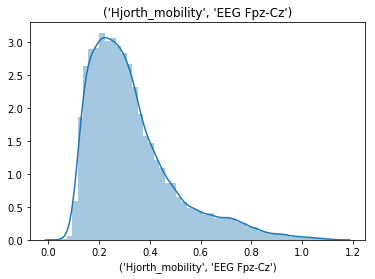

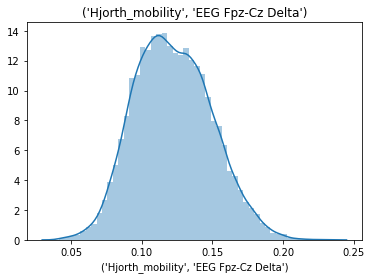

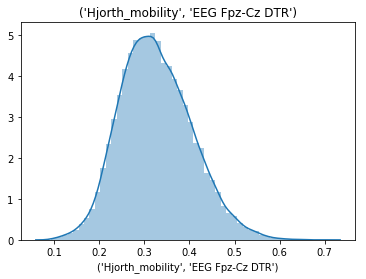

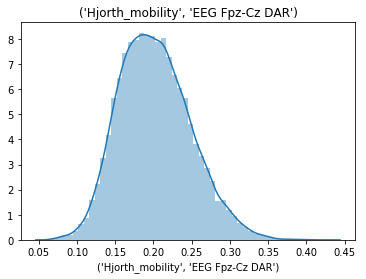

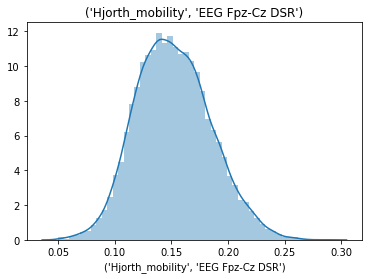

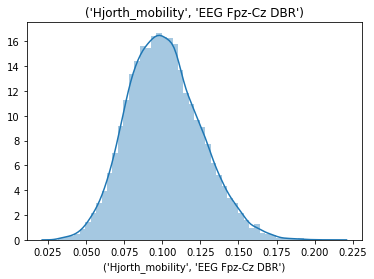

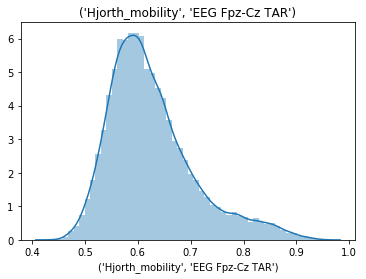

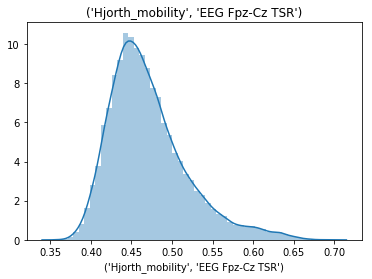

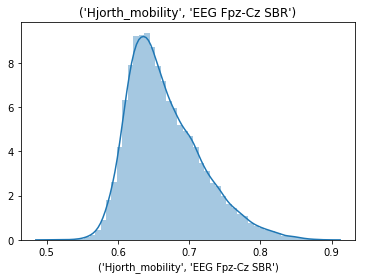

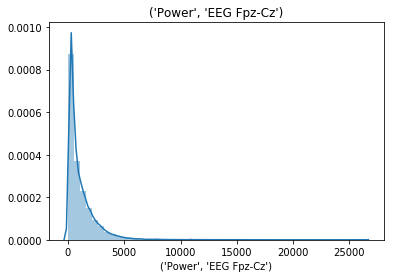

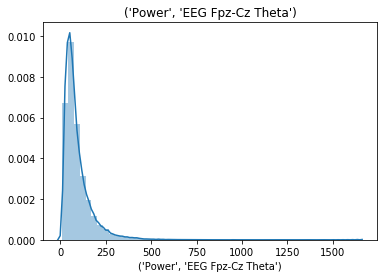

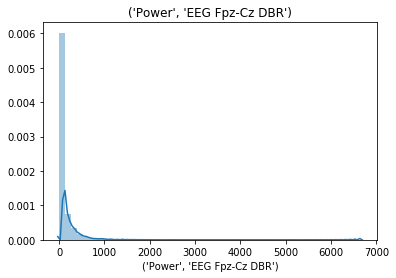

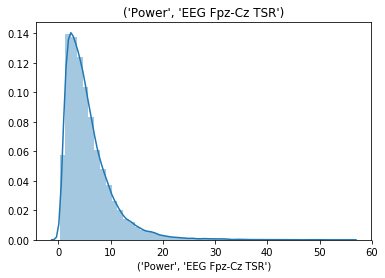

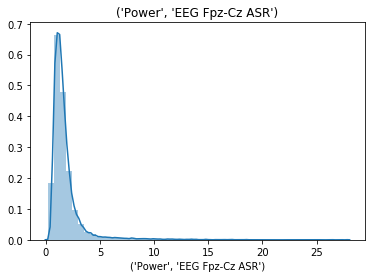

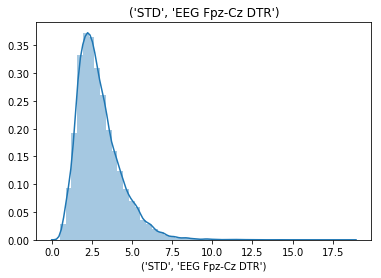

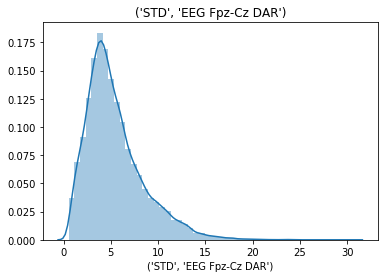

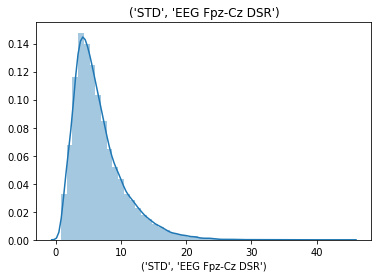

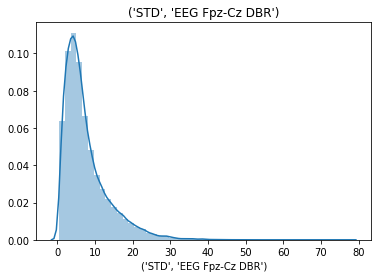

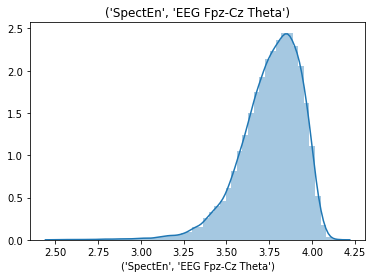

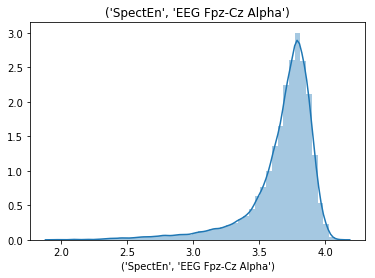

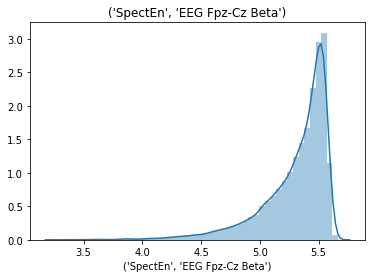

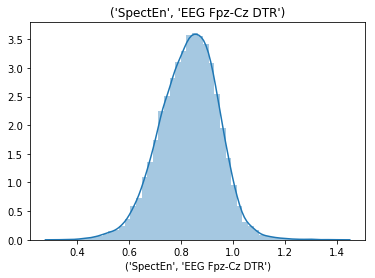

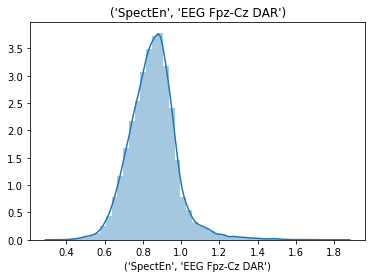

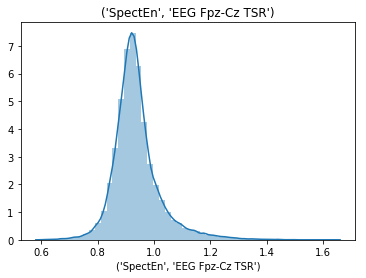

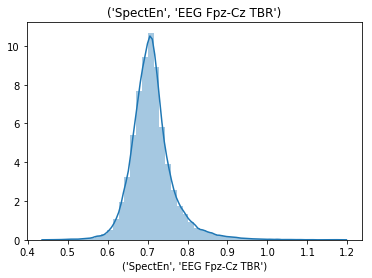

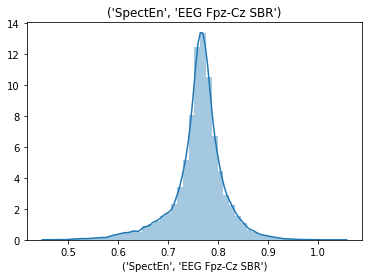

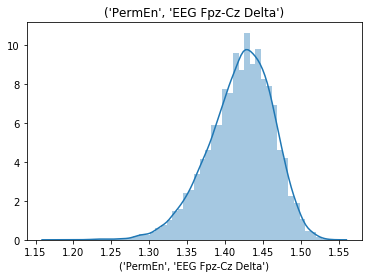

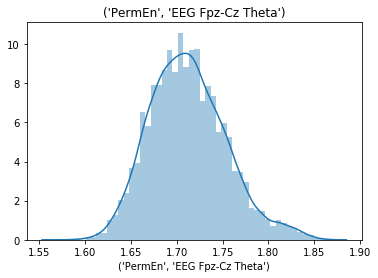

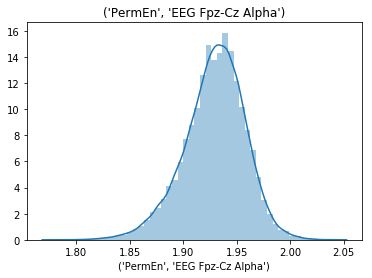

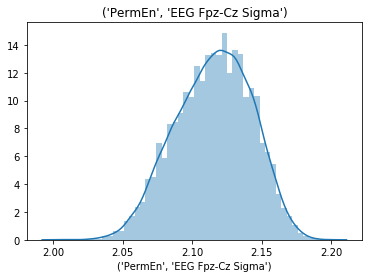

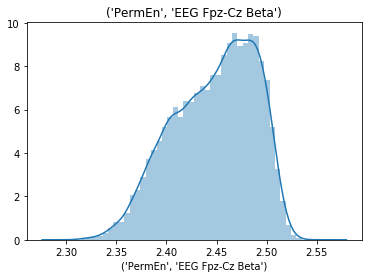

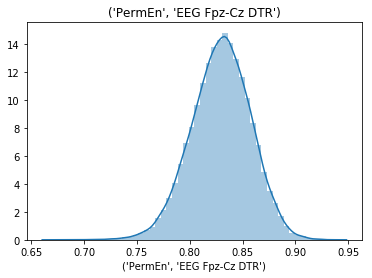

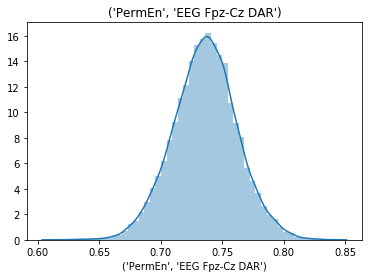

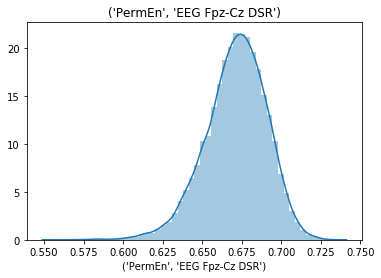

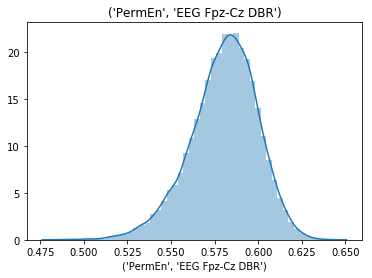

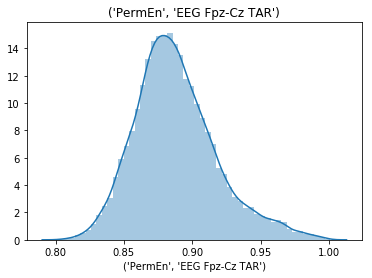

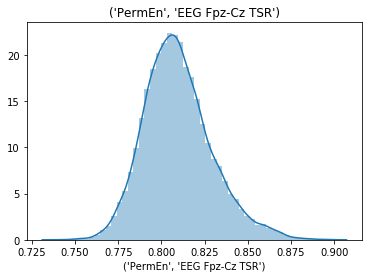

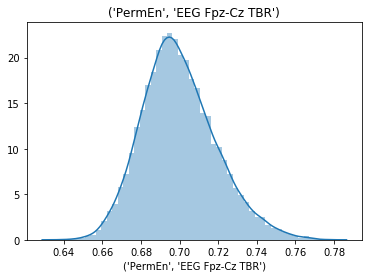

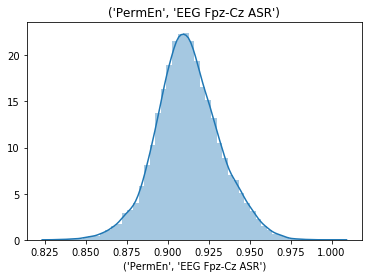

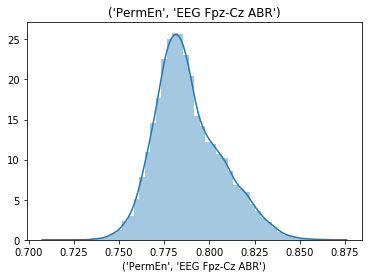

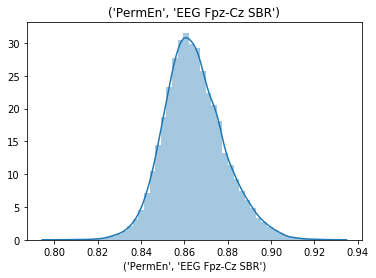

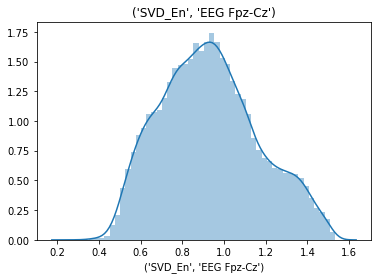

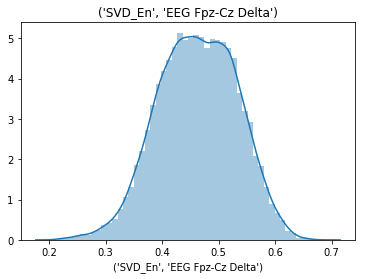

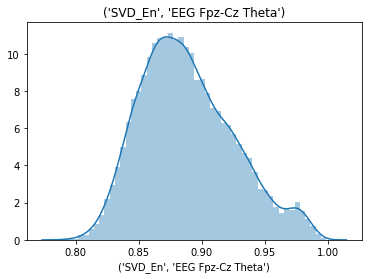

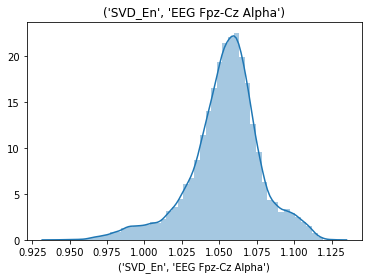

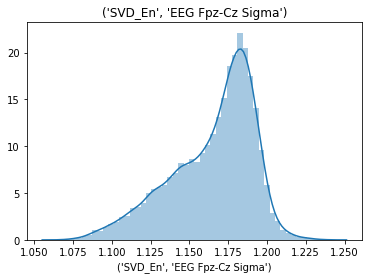

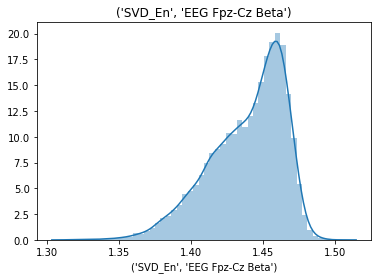

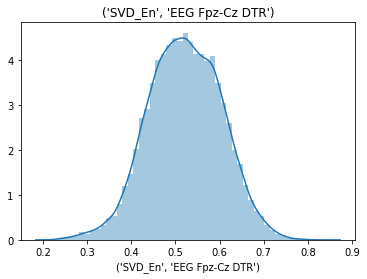

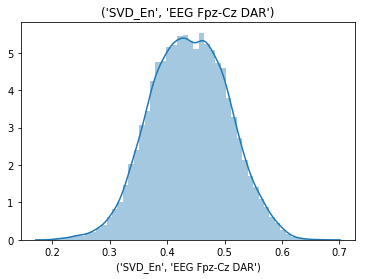

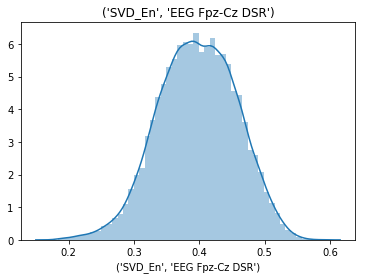

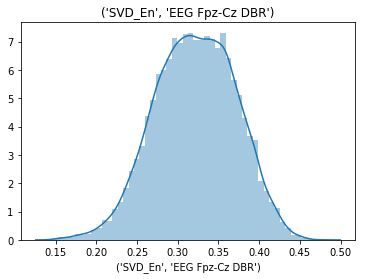

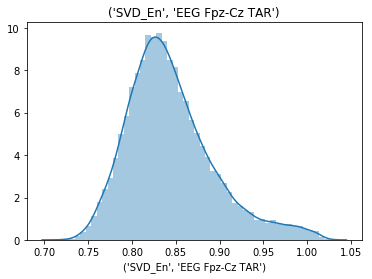

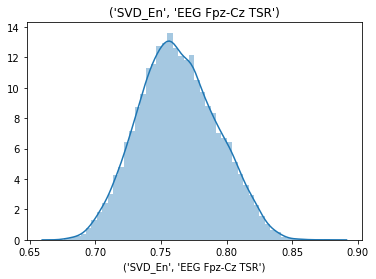

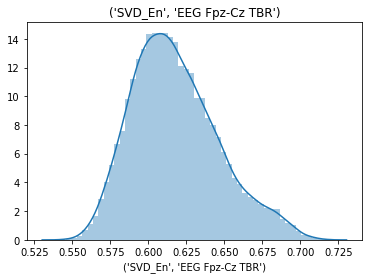

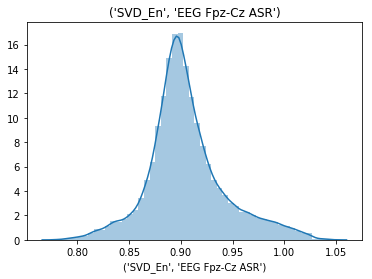

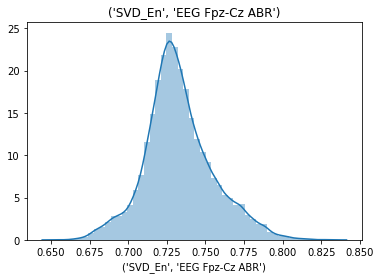

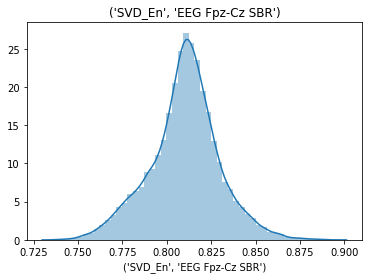

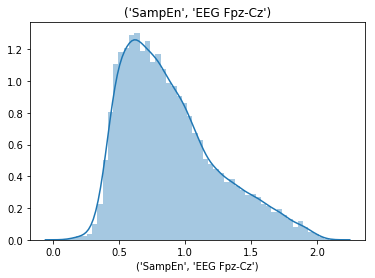

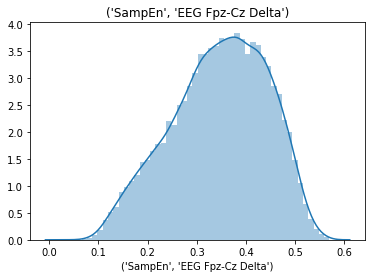

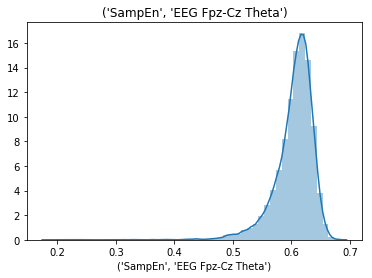

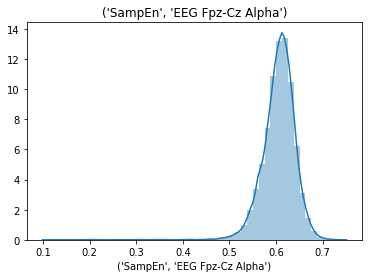

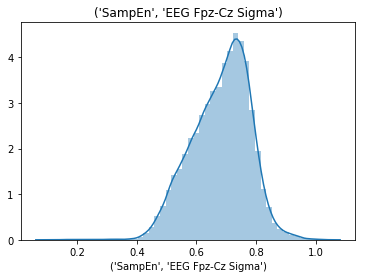

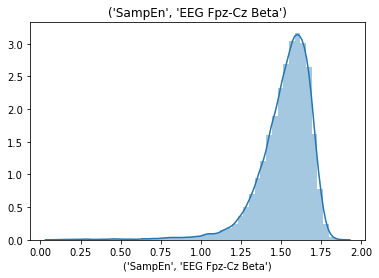

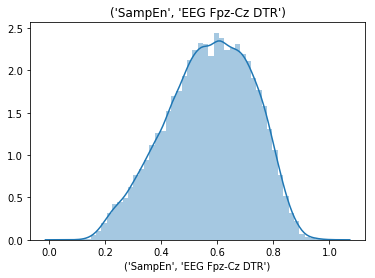

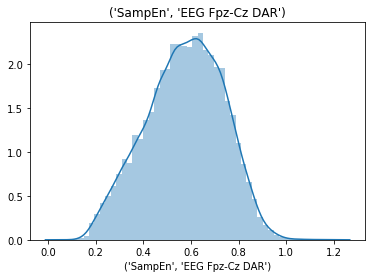

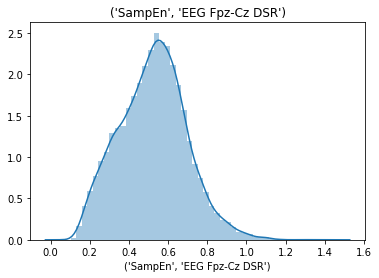

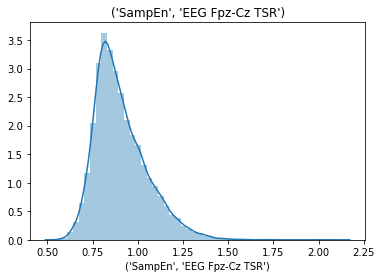

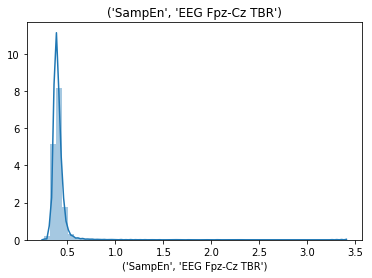

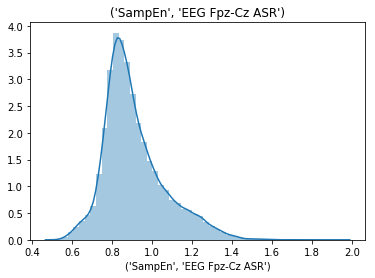

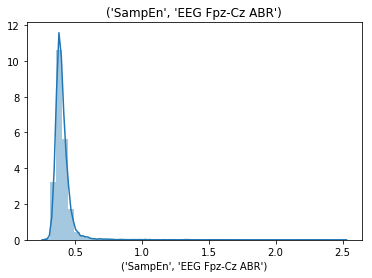

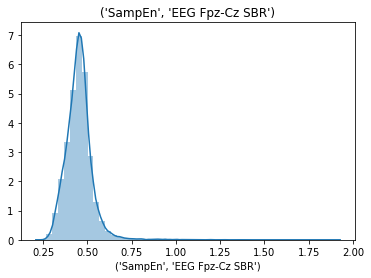

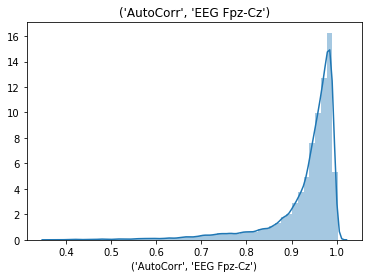

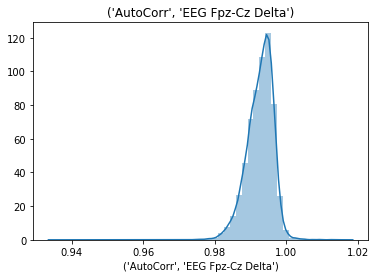

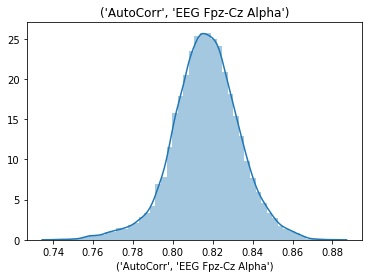

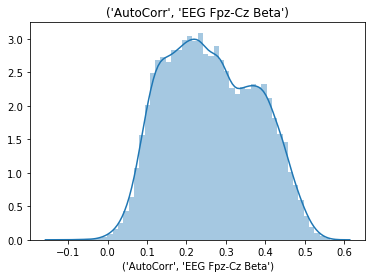

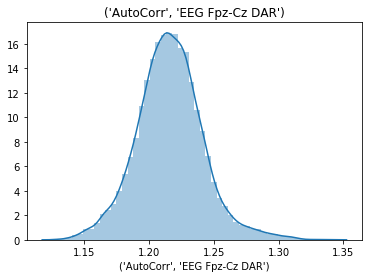

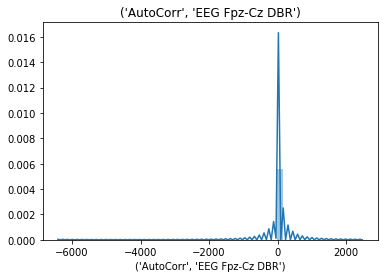

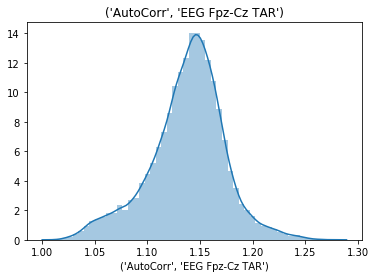

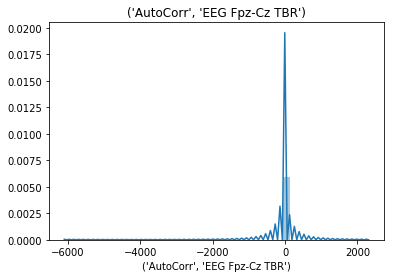

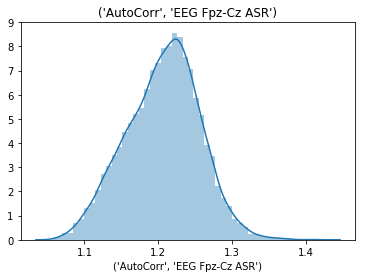

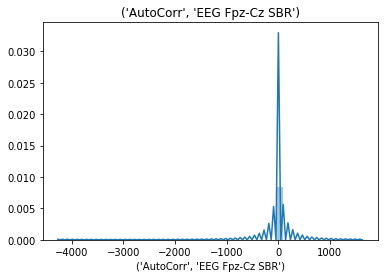

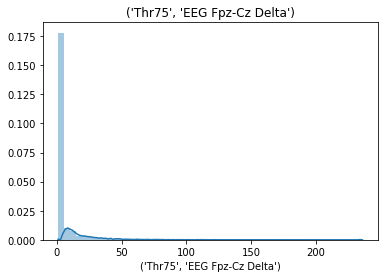

In [38]:
results_dir = 'C:/Users/vita7/OneDrive/Documents/Github/EEG_SleepStage_Analysis/KDE/'

if not os.path.isdir(results_dir): 
    os.makedirs(results_dir)

# Dist + KDE
for col in list(train_X.columns):
    sns.distplot(train_X[col])
    plt.title(col)
    plt.savefig(results_dir + str(col) + '_KDE.png')
    plt.show()

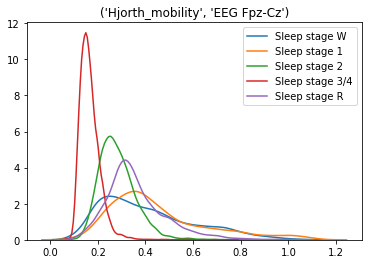

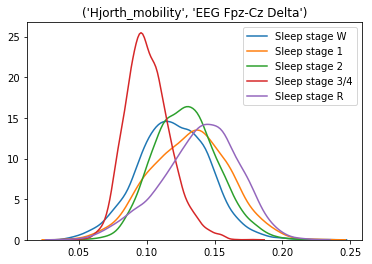

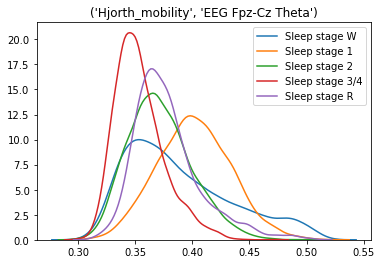

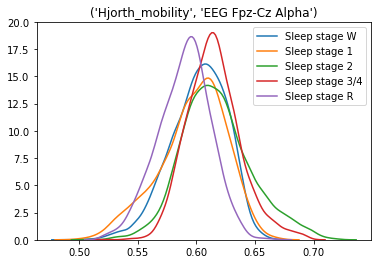

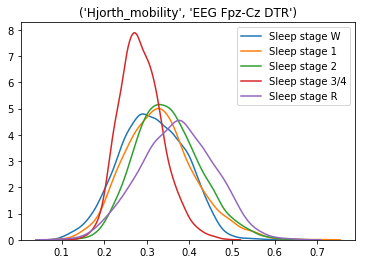

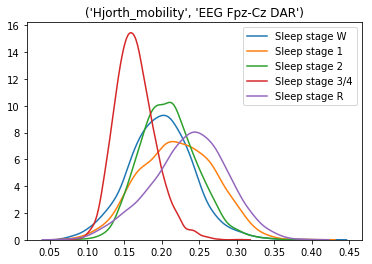

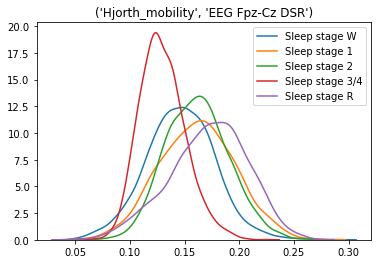

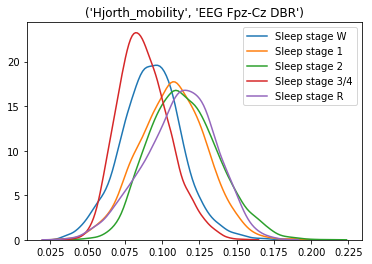

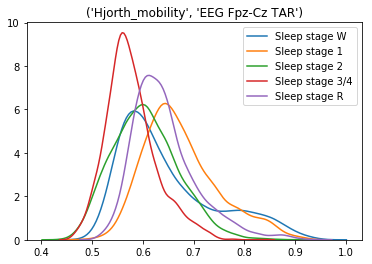

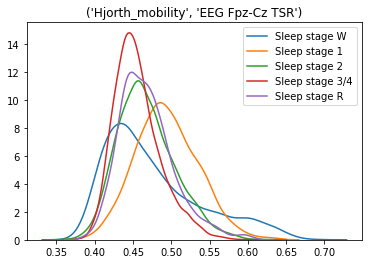

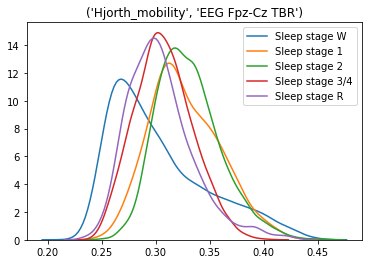

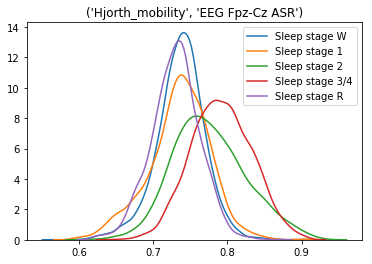

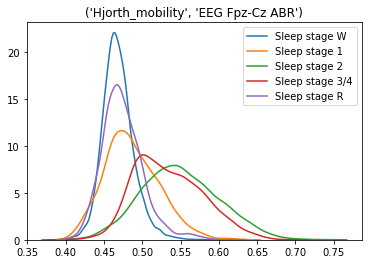

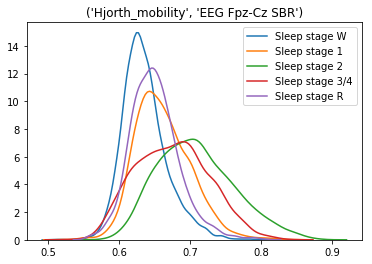

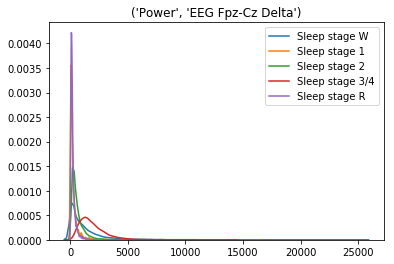

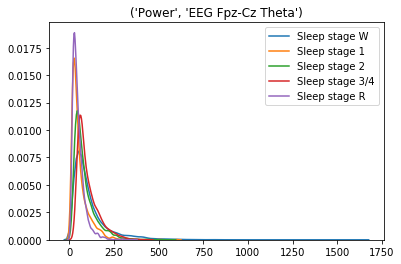

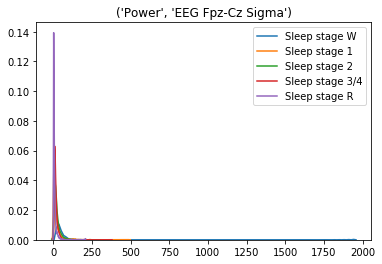

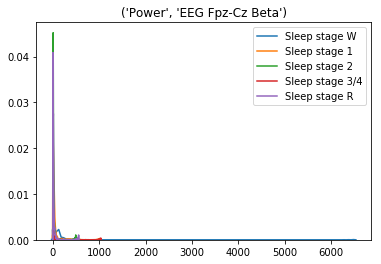

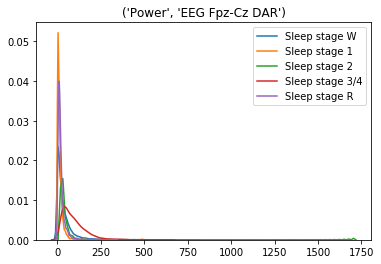

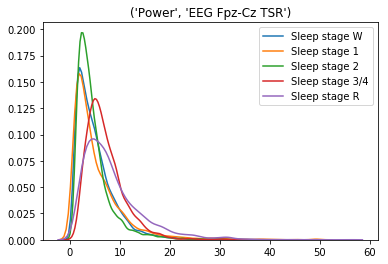

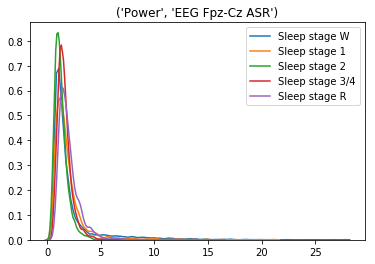

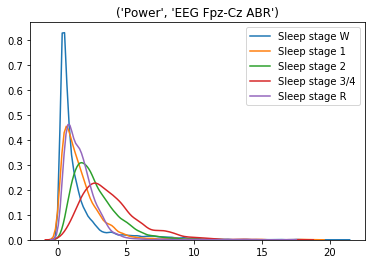

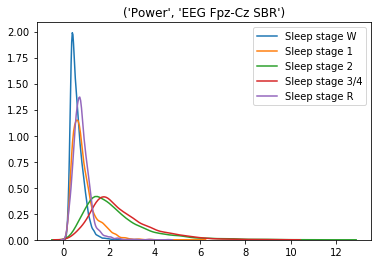

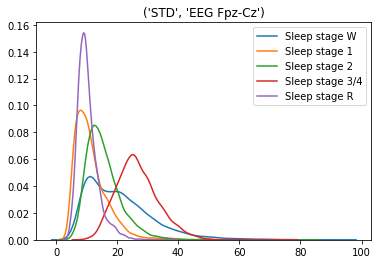

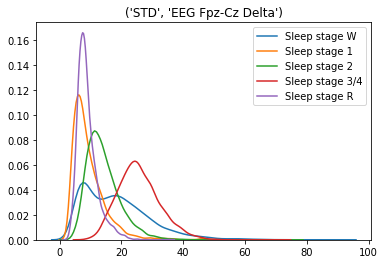

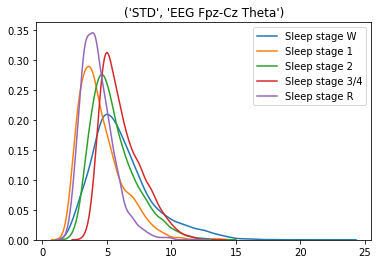

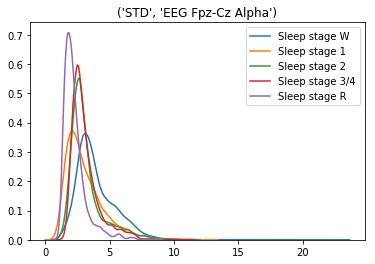

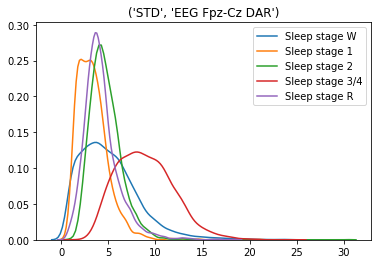

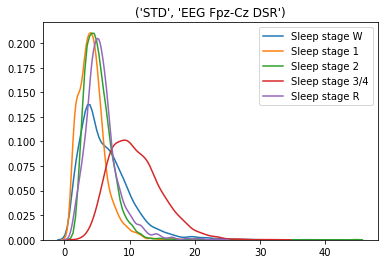

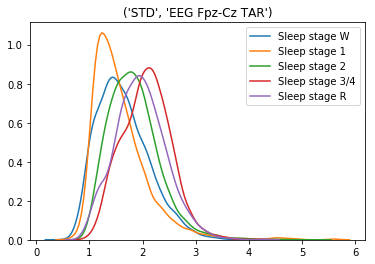

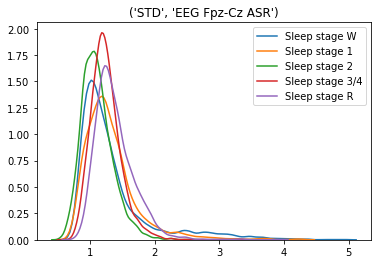

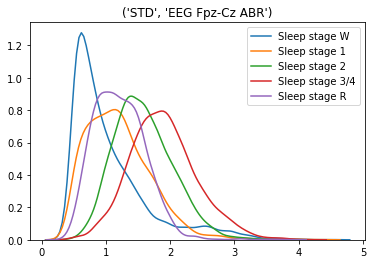

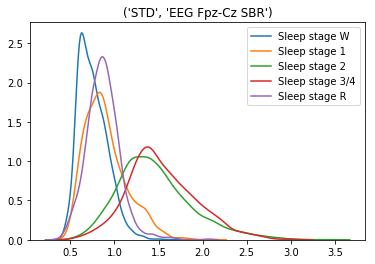

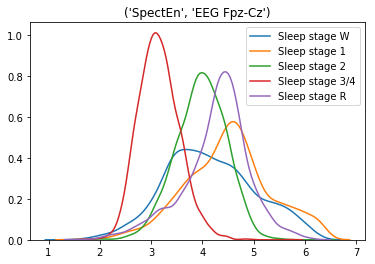

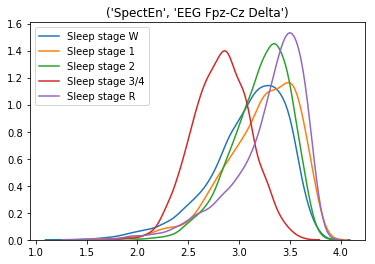

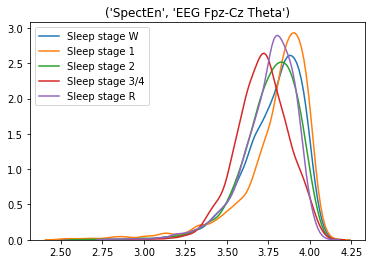

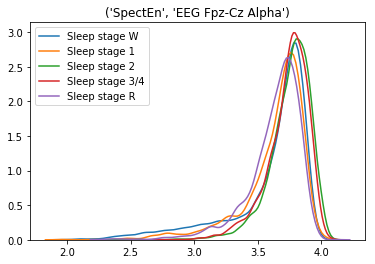

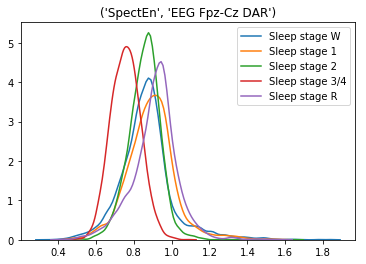

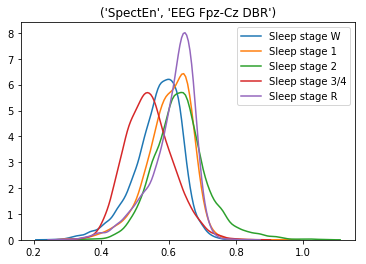

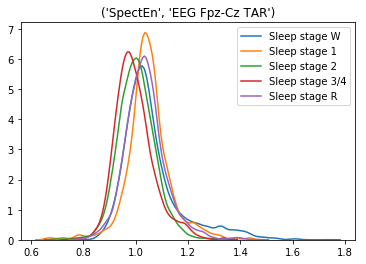

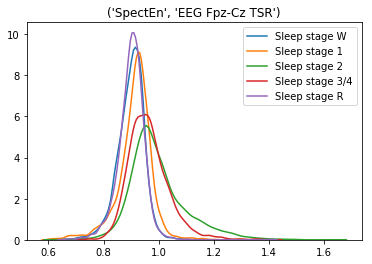

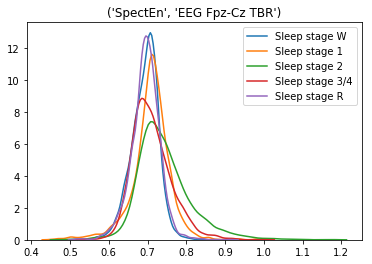

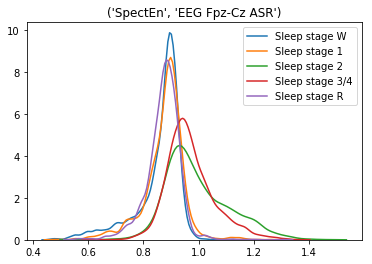

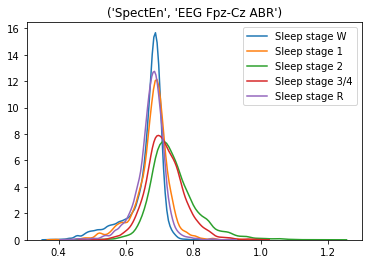

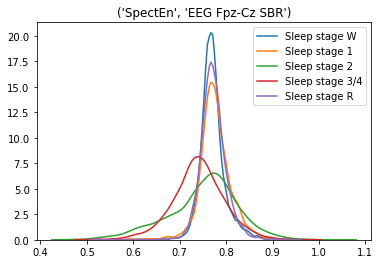

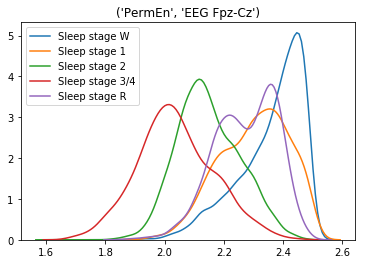

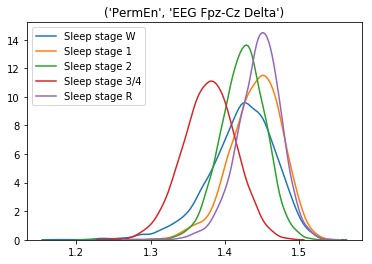

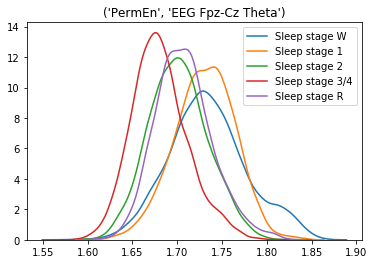

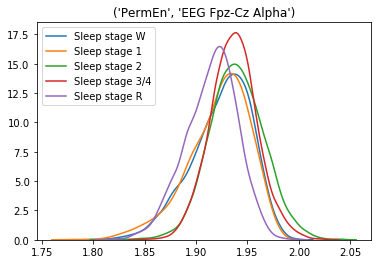

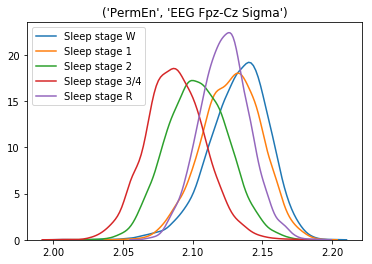

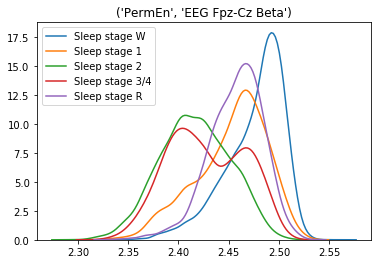

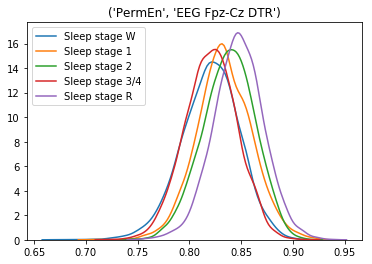

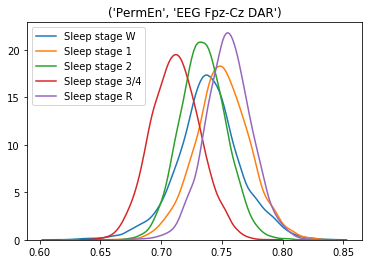

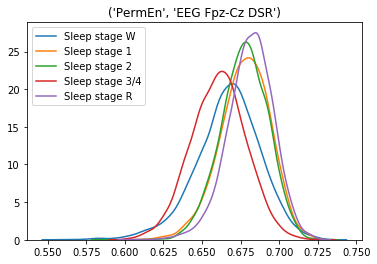

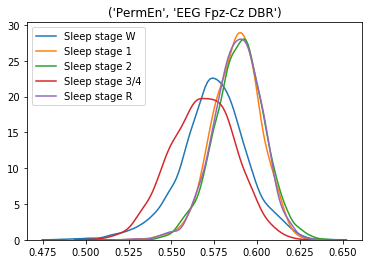

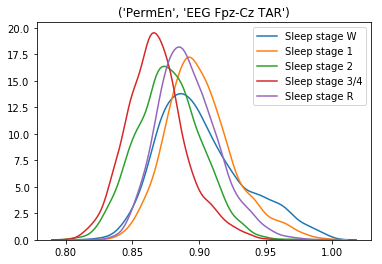

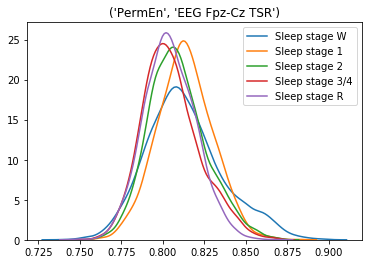

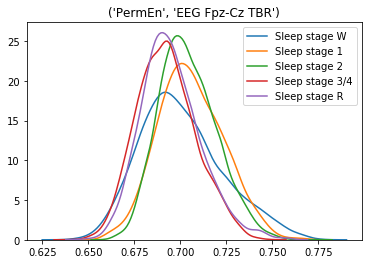

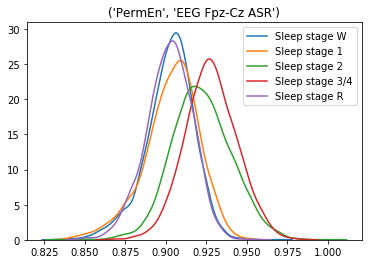

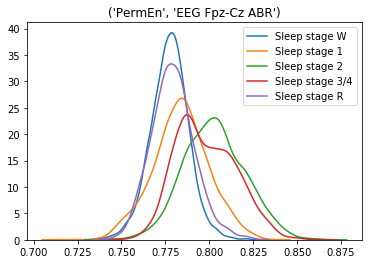

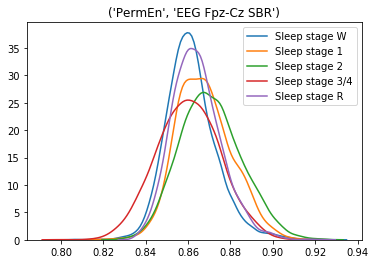

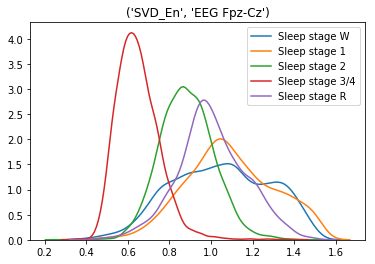

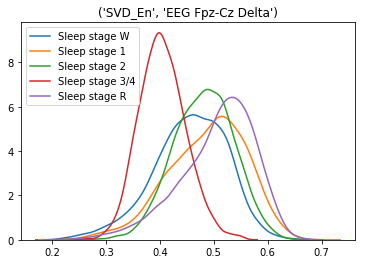

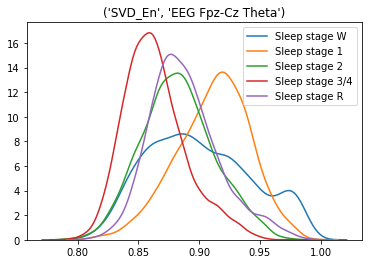

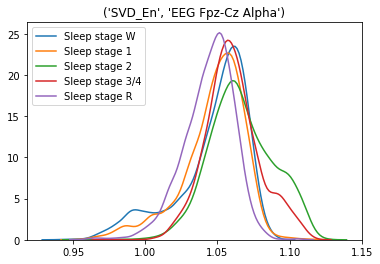

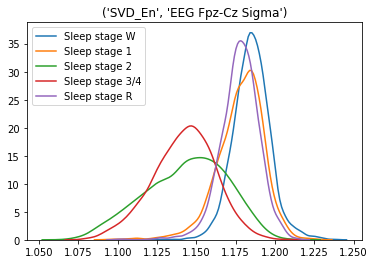

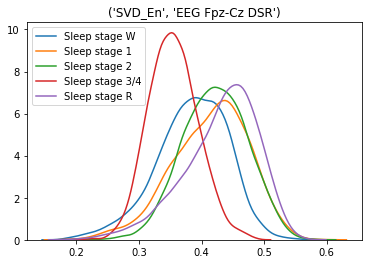

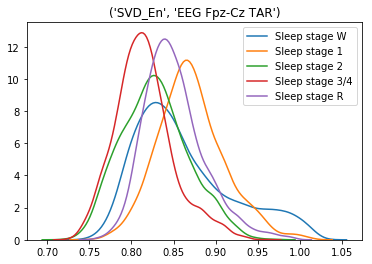

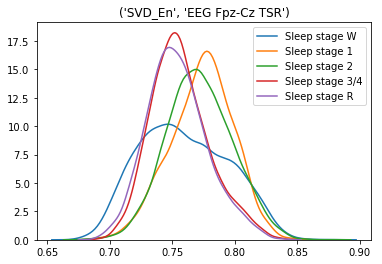

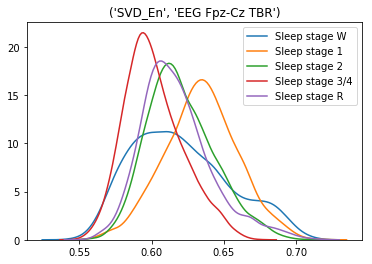

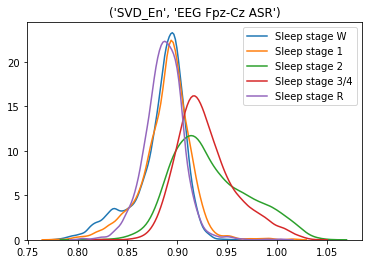

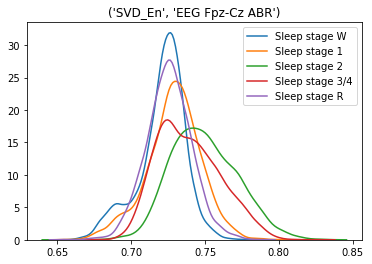

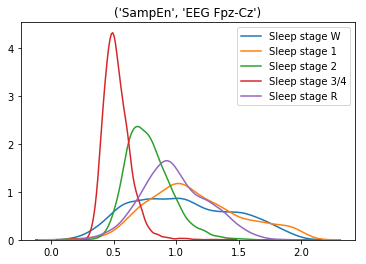

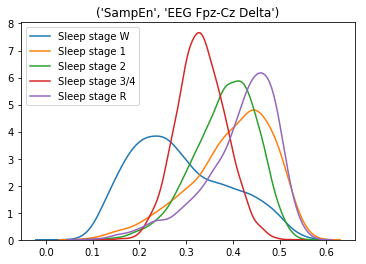

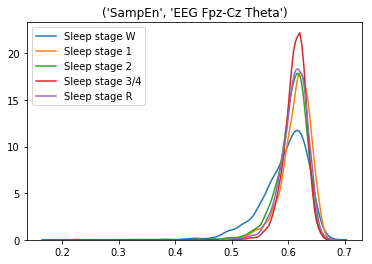

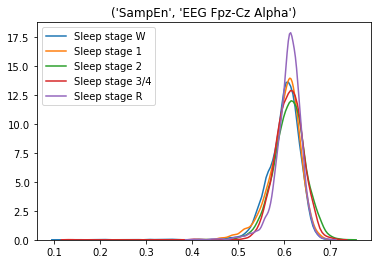

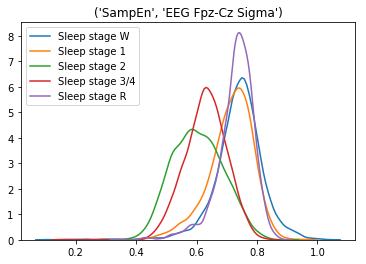

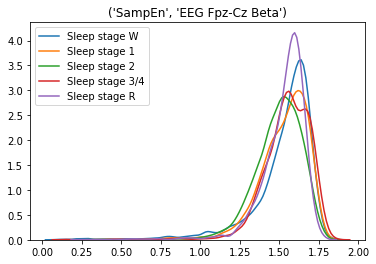

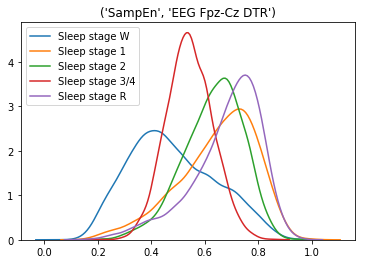

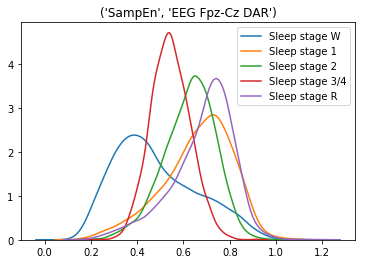

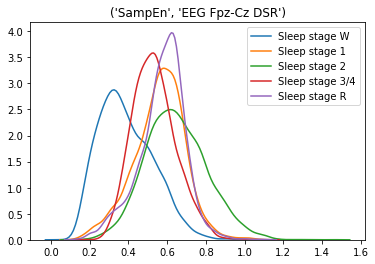

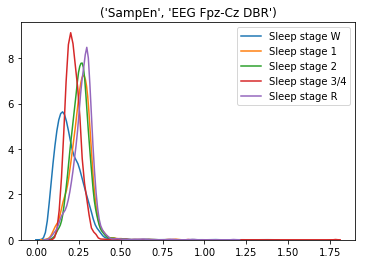

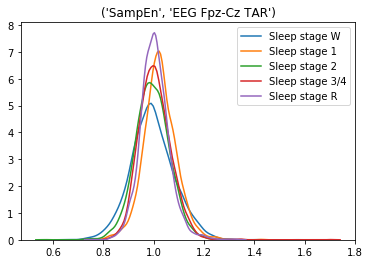

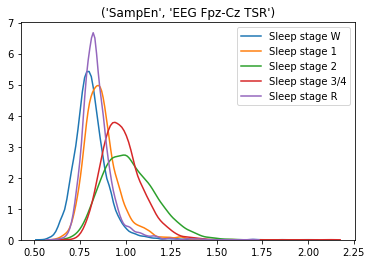

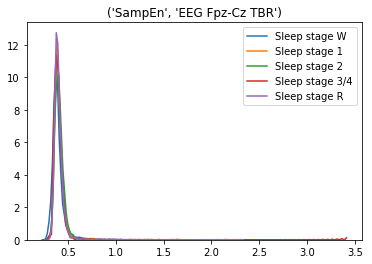

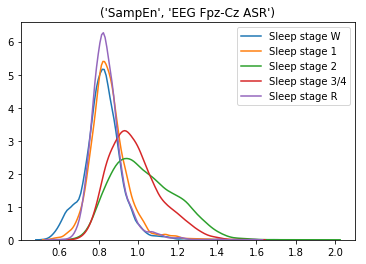

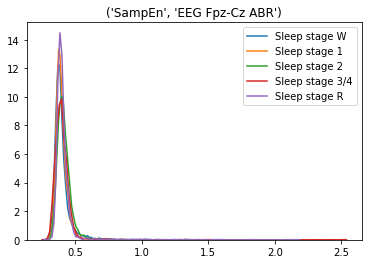

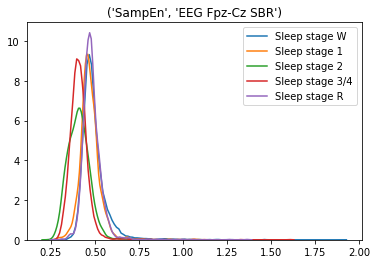

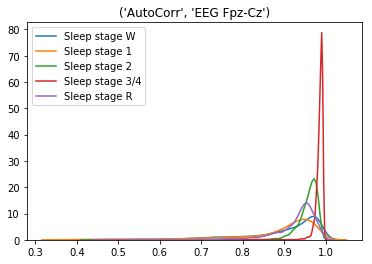

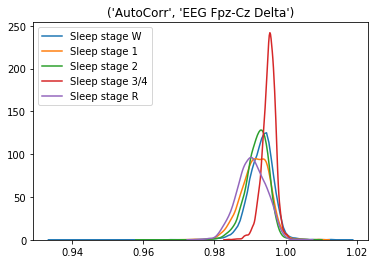

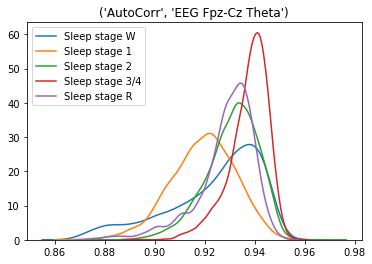

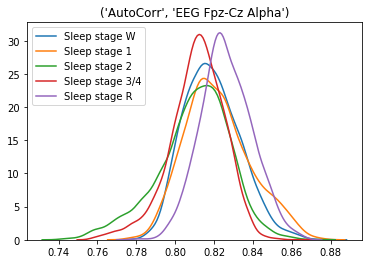

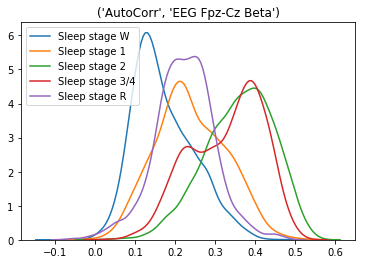

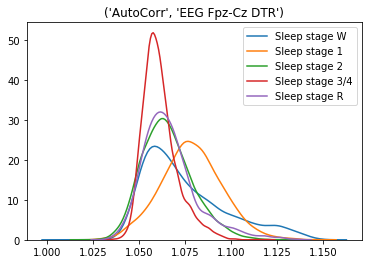

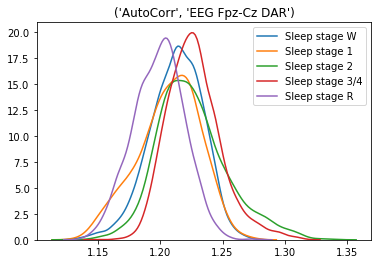

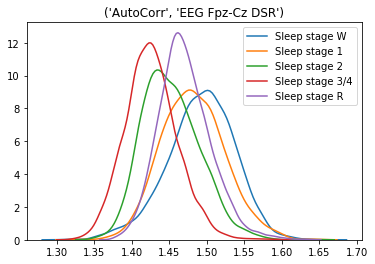

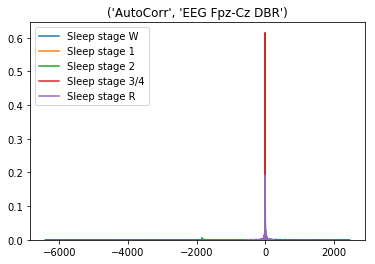

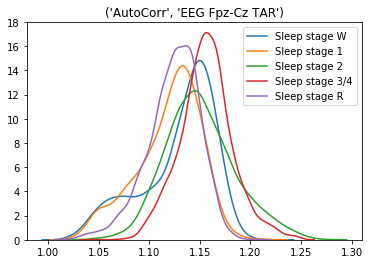

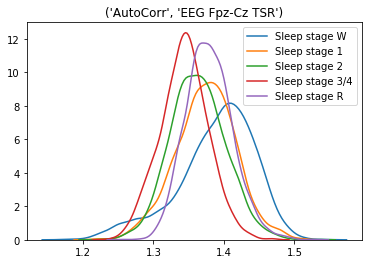

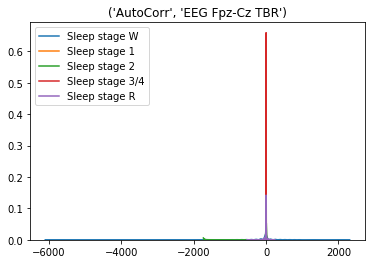

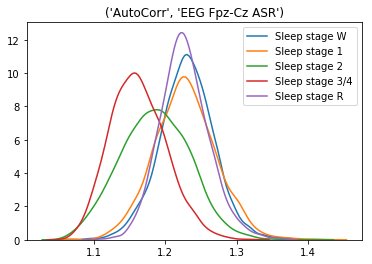

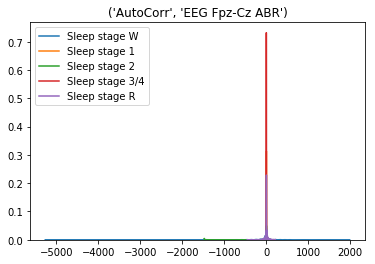

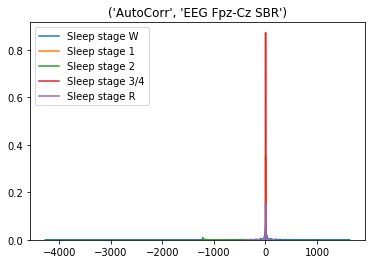

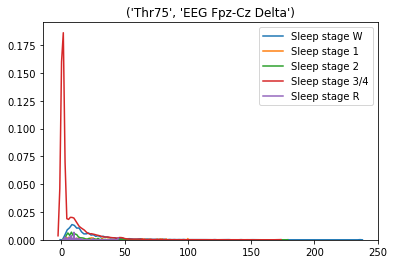

In [39]:
results_dir = 'C:/Users/vita7/OneDrive/Documents/Github/EEG_SleepStage_Analysis/Stage_KDE/'

if not os.path.isdir(results_dir): 
    os.makedirs(results_dir)

for col in list(train_X.columns):
    plt.title(col)
    for stage in list(event_id.keys()):
        sns.kdeplot(df[df['condition'] == stage][col], label=stage)
    plt.savefig(results_dir + str(col) + '_stage_KDE.png')
    plt.show()

### Correlation matrix

results_dir = 'C:/Users/vita7/OneDrive/Documents/Github/EEG_SleepStage_Analysis/Correlation matrix/'

if not os.path.isdir(results_dir): 
    os.makedirs(results_dir)
    
for col in tr_df.columns.get_level_values(1).unique()[1:]:
    df_corr = tr_df.xs(col,level=1,axis=1)[['Power','STD']].corr()
    plt.figure()
    plt.title(col)
    sns.heatmap(df_corr,annot=True)
    plt.savefig(results_dir + str(col) + '_Correlation matrix.png')
    